In [1]:
!pip install tensorflow==2.9.1 -q


In [2]:
#!pip install --quiet --user git+https://github.com/hmmlearn/hmmlearn
#from hmmlearn import hmm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense,BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
#from tensorflow.keras.losses import KLDivergence

from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#load Data


df = pd.read_csv('/content/stapler-ds (1).csv',parse_dates=True)
df

,Unnamed: 0,id,TimeMS,Avg_Velocity,PWM_Output,SG_NoFilter,Setpoint,StrainGage,avg_current,current_filter,ticks,True_Endstop_Time_ms,Articulation,Tissue,Tissue_Thickness_inch,Firing_Type
0,0,100,0,0.00,153,11,33750,1,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
1,1,100,1,0.00,165,11,33750,2,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
2,2,100,2,0.00,176,11,33750,4,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
3,3,100,3,0.00,188,11,33750,5,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
4,4,100,4,0.00,199,11,33750,6,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183005,3183005,97,4642,93.75,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183006,3183006,97,4643,62.50,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183007,3183007,97,4643,62.50,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183008,3183008,97,4644,31.25,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted


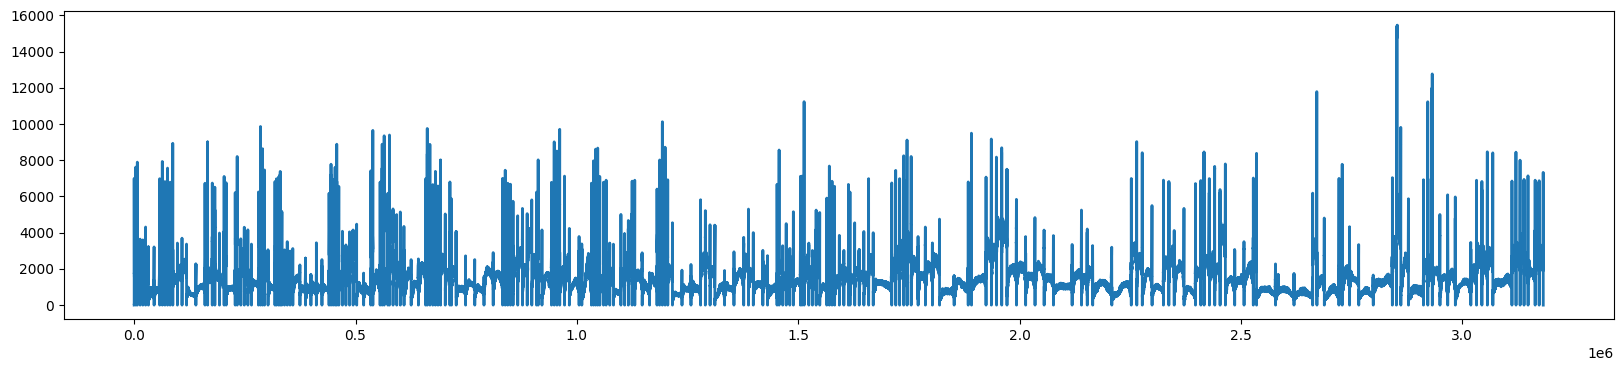

In [4]:
df.index.freq = 'TimeMS'
df.shape
df.columns
plt.figure(figsize=(20, 4))
plt.plot(df.avg_current, linewidth=2)
plt.show()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame 'df'

cols = ['id', 'TimeMS', 'Avg_Velocity', 'PWM_Output', 'SG_NoFilter', 'Setpoint', 'StrainGage', 'avg_current', 'current_filter', 'ticks', 'True_Endstop_Time_ms', 'Articulation', 'Tissue', 'Tissue_Thickness_inch', 'Firing_Type']

df = df[cols].rename({'True_Endstop_Time_ms':'Anomaly_At_Time_ms'}, axis=1)

measures = ['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output', 'Anomaly_At_Time_ms', 'id', 'TimeMS']

measures_1 = ['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output']




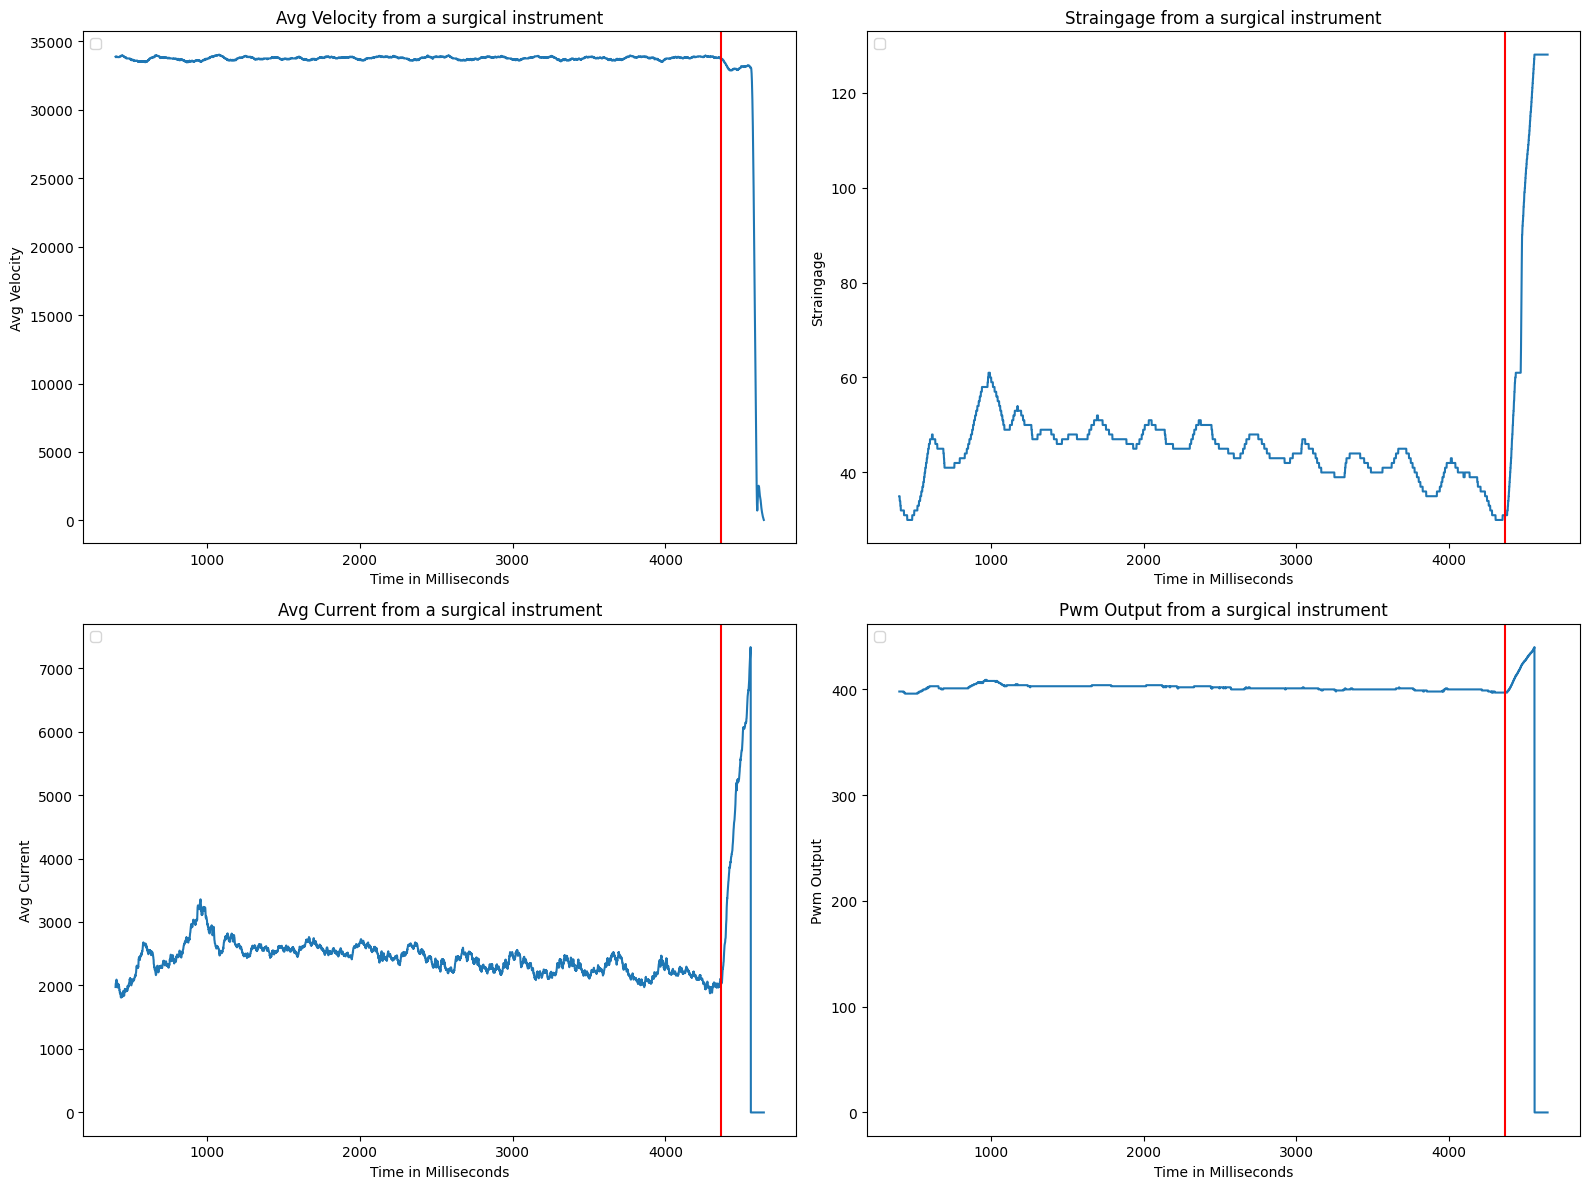

In [6]:
def plot_measure(df):
    e = np.unique(df['Anomaly_At_Time_ms'])[0]
    df = df[df.TimeMS > 400]

    plt.figure(figsize=(16, 12))

    for i, measure in enumerate(measures_1):  # Loop through the measures_1 list
        plt.subplot(2, 2, i + 1)
        plt.title(measure.replace('_', ' ').title() + ' from a surgical instrument')
        plt.xlabel('Time in Milliseconds')
        plt.ylabel(measure.replace('_', ' ').title())
        plt.plot(df['TimeMS'], df[measure])
        plt.legend(loc="upper left")
        plt.axvline(e, color='r')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

df_97 = df[df["id"] == 97]

fig1 = plot_measure(df_97)

In [7]:
cols = ['id', 'TimeMS', 'Avg_Velocity', 'PWM_Output', 'SG_NoFilter', 'Setpoint', 'StrainGage', 'avg_current', 'current_filter', 'ticks', 'True_Endstop_Time_ms', 'Articulation', 'Tissue', 'Tissue_Thickness_inch', 'Firing_Type']

measures = ['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output', 'Anomaly_At_Time_ms', 'id', 'TimeMS']
measures_1=['avg_current']
for i in range(1,6):
  measure=measures[i-1]
  print(measure.title())
df=df[measures]

Avg_Velocity
Straingage
Avg_Current
Pwm_Output
Anomaly_At_Time_Ms


In [8]:
def plot_measure(df):
  e=np.unique(df['Anomaly_At_Time_ms'])[0]
  df=df[df.TimeMS > 400]
  #plt.plot('TimeMS','StrainGage',data=df)
  #plt.plot('TimeMS','Avg_Velocity',data=df)
  plt.figure(figsize=(16,12))
  for i in range(1,5):
    measure=measures_1[i-1]
    plt.subplot(2,2,i)
    plt.title(measure.title() + ' from a surgical instrument')
    # naming the x axis
    plt.xlabel('Time in Milliseconds')
    # naming the y axis
    plt.ylabel(measure.title())
    plt.plot('TimeMS',measure,data=df)
    #plt.plot('TimeMS','avg_current',data=df)
    plt.legend(loc="upper left")
    plt.axvline(e, color='r')
  plt.show()

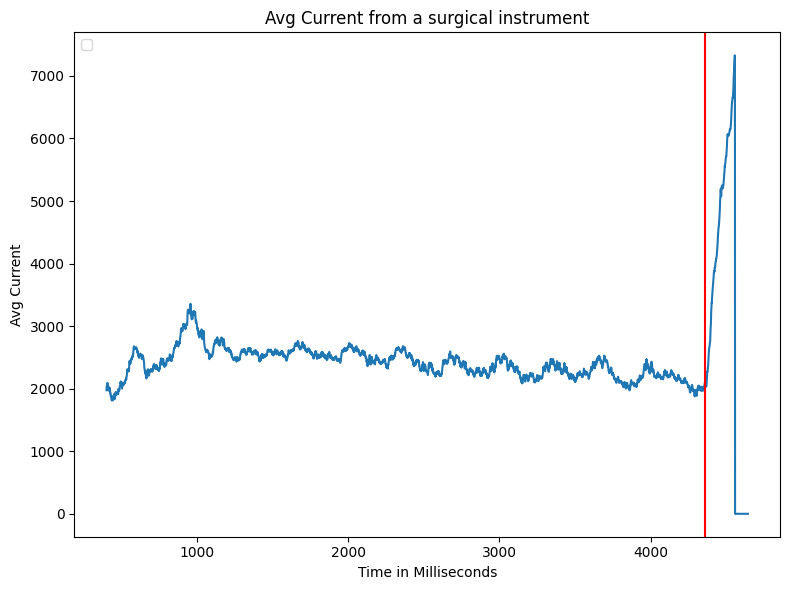

In [9]:

def plot_avg_current(df):
    e = np.unique(df['Anomaly_At_Time_ms'])[0]
    df = df[df.TimeMS > 400]

    plt.figure(figsize=(8, 6))

    measure = measures_1[0]  # Since there's only one measure, no need for a loop
    plt.title(measure.replace('_', ' ').title() + ' from a surgical instrument')
    plt.xlabel('Time in Milliseconds')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.plot(df['TimeMS'], df[measure])
    plt.legend(loc="upper left")
    plt.axvline(e, color='r')

    plt.tight_layout()  # Adjust spacing
    plt.savefig('plot4.eps', format='eps')
    plt.show()
measures_1=['avg_current']
df_97 = df[df["id"] == 97]

plot_avg_current(df_97)

In [10]:
df[['TimeMS','id']].groupby('id').count()

,TimeMS
id,
2,3764
3,3681
4,7436
5,7468
6,7376
...,...
366,12422
368,22102
370,12286


In [11]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming your DataFrame is named 'df'
# ... (previous code to define 'df' and other steps)

# Step 6: Pad sequences to ensure each 'id' has the same length as the maximum sequence length
max_seq_length = df[['TimeMS', 'id']].groupby('id').count().max().values[0]

# Create a dictionary to store sequences for each 'id' group
id_sequences = {}

# Group data by 'id' and store sequences in the dictionary
for id_group in df.groupby('id'):
    id_value, group_df = id_group
    sequence = group_df['TimeMS'].values
    id_sequences[id_value] = sequence

# Pad each sequence individually using the pad_sequences function for 'TimeMS'
padded_sequences = [pad_sequences([sequence], maxlen=max_seq_length, padding='pre', value=0)[0] for sequence in id_sequences.values()]

# Initialize a dictionary to store the padded sequences for each column
padded_data_dict = {}

# Pad each sequence individually using the pad_sequences function for other columns
for col in df.columns:
    if col not in ['TimeMS', 'id']:
        sequences = [group_df[col].values for _, group_df in df.groupby('id')]
        padded_sequences_col = [pad_sequences([sequence], maxlen=max_seq_length, padding='pre', value=0)[0] for sequence in sequences]
        padded_data_dict[col] = np.concatenate(padded_sequences_col, axis=0)

# Add 'Padded_TimeMS' column to the dictionary
padded_data_dict['Padded_TimeMS'] = np.concatenate(padded_sequences, axis=0)

# Add 'id' column to the dictionary
padded_data_dict['id'] = np.repeat(df['id'].unique(), max_seq_length)

# Create the final DataFrame with padded sequences for all columns
padded_df = pd.DataFrame(data=padded_data_dict)

# Now, 'padded_df' contains the data with padded sequences, and each 'id' has the same length as the maximum sequence length


In [12]:
padded_df[['Padded_TimeMS','id']].groupby('id').count()



,Padded_TimeMS
id,
2,43968
3,43968
4,43968
5,43968
6,43968
...,...
366,43968
368,43968
370,43968


In [13]:
import pandas as pd

# Assuming your dataset is already loaded into the DataFrame called "padded_df"
# If not, you can load it from your data source using pd.read_csv or any other method.

# Add a new column "Label" and initialize it with 0
padded_df['Label'] = 0

# Update "Label" to 1 for rows where "Padded_TimeMS" is greater than "Anomaly_At_Time_ms"
padded_df.loc[padded_df['Padded_TimeMS'] > padded_df['Anomaly_At_Time_ms'], 'Label'] = 1



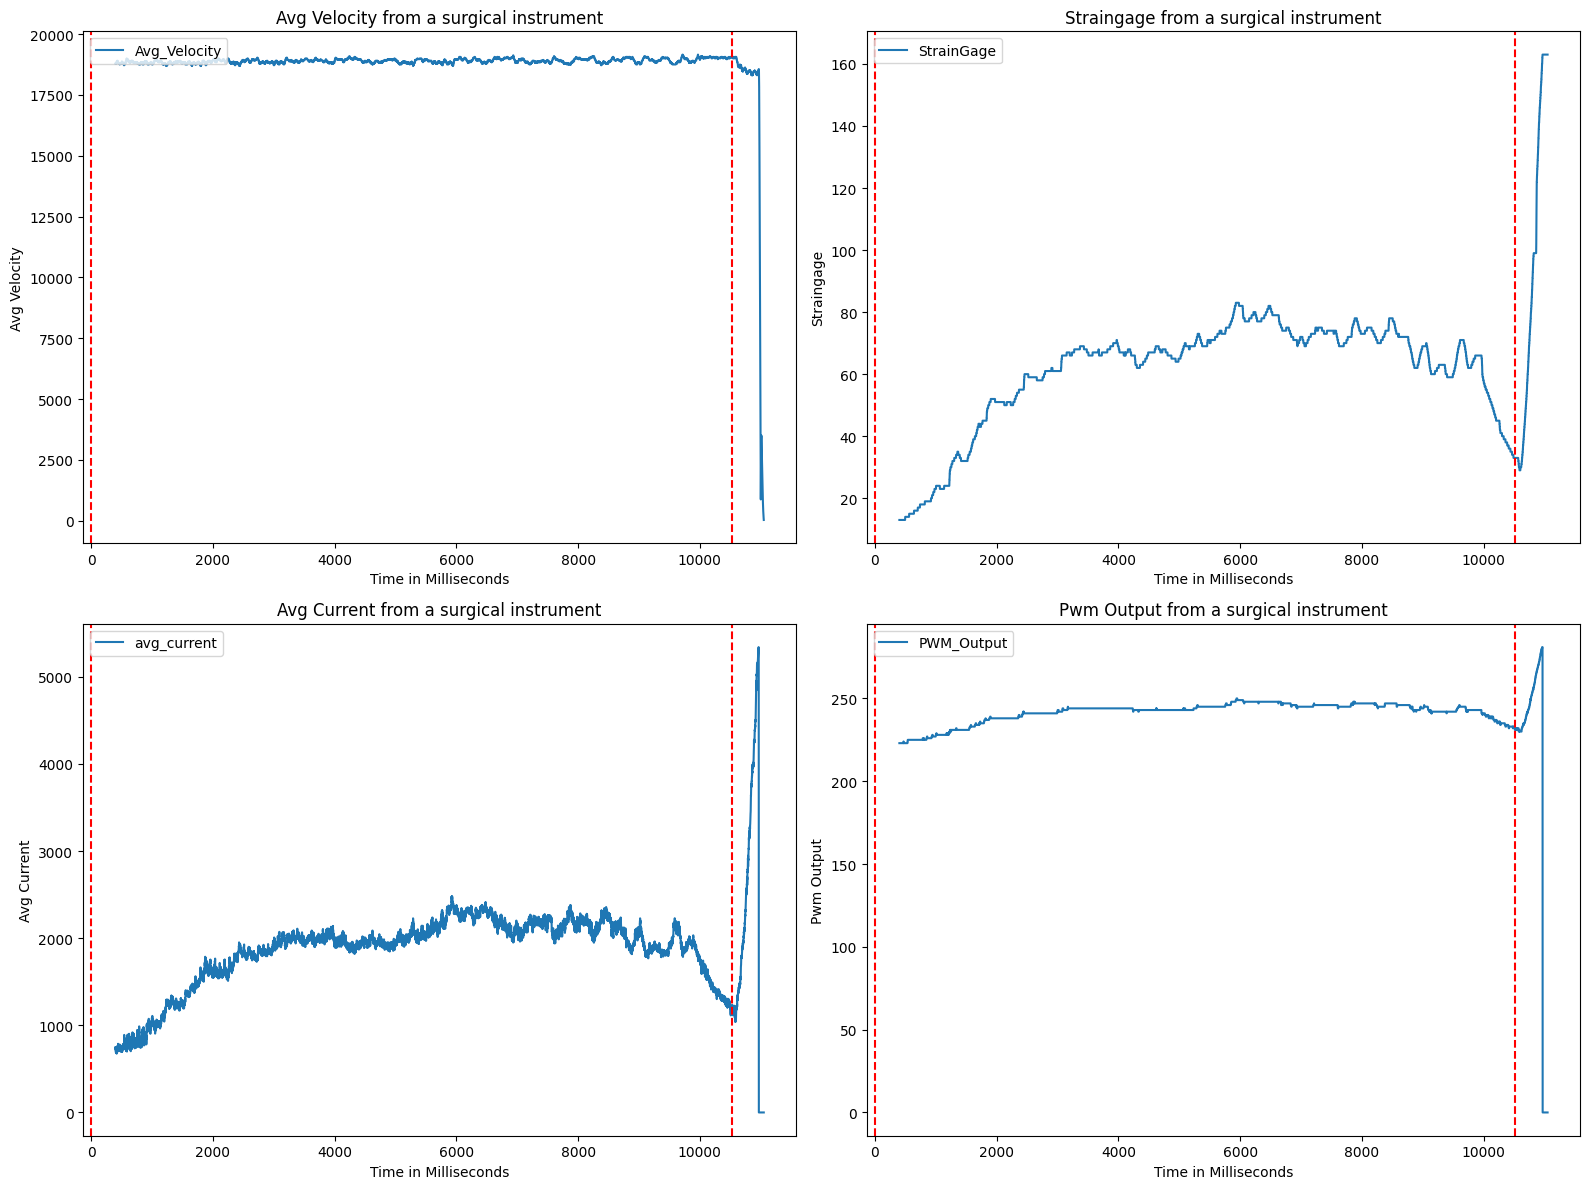

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_measure(padded_df):
    unique_times = np.unique(padded_df['Anomaly_At_Time_ms'])
    df = padded_df[padded_df['Padded_TimeMS'] > 400]

    plt.figure(figsize=(16, 12))

    for i, measure in enumerate(['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output']):
        plt.subplot(2, 2, i+1)
        plt.title(measure.replace('_', ' ').title() + ' from a surgical instrument')
        plt.xlabel('Time in Milliseconds')
        plt.ylabel(measure.replace('_', ' ').title())
        plt.plot('Padded_TimeMS', measure, data=df)

        # Add vertical lines for each unique Anomaly_At_Time_ms value
        for t in unique_times:
            plt.axvline(t, color='r', linestyle='--')

        plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

# Assuming you have the 'padded_df' DataFrame
padded_df_97 = padded_df[padded_df["id"] == 97]
plot_measure(padded_df_97)

In [15]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id,Label
0,0,0,0,0,0,0,100,0
1,0,0,0,0,0,0,100,0
2,0,0,0,0,0,0,100,0
3,0,0,0,0,0,0,100,0
4,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97,1
10991996,62,163,0,0,10522,11050,97,1
10991997,62,163,0,0,10522,11050,97,1
10991998,31,163,0,0,10522,11051,97,1


In [16]:
import numpy as np

# Separate features and labels for training and testing sets
#X = padded_df.drop(['Label', 'id', 'Anomaly_At_Time_ms', 'Padded_TimeMS'], axis=1)
X = padded_df[['Avg_Velocity']]
Y = padded_df[['Label']]

# Convert data to numpy arrays
X_np = X.values
Y_np = Y.values.ravel()

# Separate normal and faulty samples
X_normal = X_np[Y_np == 0]
X_faulty = X_np[Y_np == 1]
Y_normal = Y_np[Y_np == 0]
Y_faulty = Y_np[Y_np == 1]

In [17]:
# Determine the index to split between training and testing data
split_index = int(0.9 * len(X_normal))  # 80% for training, 20% for testing

# Split the data into training and testing sets
X_train = X_normal[:split_index]
X_test_1 = X_normal[split_index:]
Y_train = Y_normal[:split_index]
Y_test_1 = Y_normal[split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test_1.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test_1.shape)

Shape of X_train: (9765453, 1)
Shape of X_test: (1085051, 1)
Shape of Y_train: (9765453,)
Shape of Y_test: (1085051,)


In [18]:
# Combine X_test_1 and X_faulty to create a new combined test set
X_test= np.concatenate((X_test_1, X_faulty), axis=0)

# Create corresponding labels for the combined test set
Y_test = np.concatenate((np.zeros(len(X_test_1)), np.ones(len(X_faulty))), axis=0)

print("Shape of X_test_combined:", X_test.shape)
print("Shape of Y_test_combined:", Y_test.shape)

Shape of X_test_combined: (1226547, 1)
Shape of Y_test_combined: (1226547,)


In [19]:
print(X_train.shape)
print(X_test.shape)

(9765453, 1)
(1226547, 1)


In [20]:
from sklearn.preprocessing import StandardScaler
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(9765453, 1)
(1226547, 1)


In [22]:
#from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


n_inputs = 64
n_features = 1
# Create generator for target data (Y_normal)
#target_generator_test = TimeseriesGenerator(Y_faulty, Y_faulty, length=n_inputs, batch_size=1024)

generator_train = TimeseriesGenerator(X_train_scaled, Y_train, length=n_inputs, batch_size=1024)

for i in range(len(generator_train)):
    x_normal, y_normal= generator_train[i]
    print(f'\n {x_normal.flatten()} and {y_normal}')

Streaming output truncated to the last 5000 lines.

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.50302698 -0.50302698 ... -0.50302698 -0.50302698
 -0.50302698] and [0 0 0 ... 0 0 0]

 [-0.50302698 -0.5030

In [72]:
# Get the length of your dataset
dataset_size = len(X_test_scaled)

# Define parameters
n_inputs = 64  # Window size (sequence length)
batch_size = 1024  # Batch size used in TimeseriesGenerator

# Calculate the total number of possible sequences
total_sequences = dataset_size - n_inputs + 1

# Calculate the total number of batches
total_batches = total_sequences // batch_size

# Print the results
print(f"Dataset size: {dataset_size}")
print(f"Total number of sequences: {total_sequences}")
print(f"Total number of batches (using batch size {batch_size}): {total_batches}")

# Iterate over batches and check for the mix of labels
for i in range(len(generator_test)):
    x_faulty, y_faulty = generator_test[i]
    print(f'Batch {i} - Labels: {np.unique(y_faulty, return_counts=True)}')


Dataset size: 1226547
Total number of sequences: 1226484
Total number of batches (using batch size 1024): 1197


NameError: name 'generator_test' is not defined

In [ ]:
mixed_batches = 0
total_batches = len(generator_test)

# Iterate over all batches
for i in range(total_batches):
    x_batch, y_batch = generator_test[i]
    unique_labels = np.unique(y_batch)

    # Check if both normal (0) and anomalous (1) labels are present
    if len(unique_labels) == 2 and set(unique_labels) == {0, 1}:
        mixed_batches += 1
        print(f"Batch {i} contains both normal and anomalous signals: {unique_labels}")

print(f"\nTotal number of batches containing both normal and anomalous samples: {mixed_batches}/{total_batches}")


Batch 2119 contains both normal and anomalous signals: [0. 1.]

Total number of batches containing both normal and anomalous samples: 1/2258


In [31]:
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator

n_inputs = 64
batch_size = 1024

# Step 1: Separate the normal (0) and anomalous (1) signals
X_normal = X_test_scaled[Y_test == 0]
Y_normal = Y_test[Y_test == 0]

X_anomalous = X_test_scaled[Y_test == 1]
Y_anomalous = Y_test[Y_test == 1]

# Step 2: Create two separate generators for normal and anomalous signals
generator_normal = TimeseriesGenerator(X_normal, Y_normal, length=n_inputs, batch_size=batch_size)
generator_anomalous = TimeseriesGenerator(X_anomalous, Y_anomalous, length=n_inputs, batch_size=batch_size)

# Step 3: Iterate over normal signal batches and ensure no mixed labels
print("Normal Signal Batches:")
mixed_batches_normal = 0
total_batches_normal = len(generator_normal)

for i in range(total_batches_normal):
    x_batch, y_batch = generator_normal[i]
    unique_labels = np.unique(y_batch)

    # Check if this batch contains only normal (0)
    if len(unique_labels) == 1 and unique_labels[0] == 0:
        print(f"Batch {i} contains only normal signals: {unique_labels}")
    else:
        mixed_batches_normal += 1
        print(f"Batch {i} contains mixed signals (which shouldn't happen): {unique_labels}")

print(f"\nTotal number of mixed batches (normal data): {mixed_batches_normal}/{total_batches_normal}")

# Step 4: Iterate over anomalous signal batches and ensure no mixed labels
print("Anomalous Signal Batches:")
mixed_batches_anomalous = 0
total_batches_anomalous = len(generator_anomalous)

for i in range(total_batches_anomalous):
    x_batch, y_batch = generator_anomalous[i]
    unique_labels = np.unique(y_batch)

    # Check if this batch contains only anomalous (1)
    if len(unique_labels) == 1 and unique_labels[0] == 1:
        print(f"Batch {i} contains only anomalous signals: {unique_labels}")
    else:
        mixed_batches_anomalous += 1
        print(f"Batch {i} contains mixed signals (which shouldn't happen): {unique_labels}")

print(f"\nTotal number of mixed batches (anomalous data): {mixed_batches_anomalous}/{total_batches_anomalous}")


Normal Signal Batches:
Batch 0 contains only normal signals: [0.]
Batch 1 contains only normal signals: [0.]
Batch 2 contains only normal signals: [0.]
Batch 3 contains only normal signals: [0.]
Batch 4 contains only normal signals: [0.]
Batch 5 contains only normal signals: [0.]
Batch 6 contains only normal signals: [0.]
Batch 7 contains only normal signals: [0.]
Batch 8 contains only normal signals: [0.]
Batch 9 contains only normal signals: [0.]
Batch 10 contains only normal signals: [0.]
Batch 11 contains only normal signals: [0.]
Batch 12 contains only normal signals: [0.]
Batch 13 contains only normal signals: [0.]
Batch 14 contains only normal signals: [0.]
Batch 15 contains only normal signals: [0.]
Batch 16 contains only normal signals: [0.]
Batch 17 contains only normal signals: [0.]
Batch 18 contains only normal signals: [0.]
Batch 19 contains only normal signals: [0.]
Batch 20 contains only normal signals: [0.]
Batch 21 contains only normal signals: [0.]
Batch 22 contains o

In [24]:
#Flattening the x
x_normal_r = x_normal.reshape((x_normal.shape[0], -1))

In [25]:
x_normal_r.shape

(525, 64)

Instructions for updating:
Colocations handled automatically by placer.
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
  1%|          | 13/2000 [00:02<04:06,  8.07it/s]

Epoch 1/1000, Batch 2/2, [D loss: 1.1720314025878906] [G loss: 1.0512603521347046]
Epoch 2/1000, Batch 2/2, [D loss: 1.1720314025878906] [G loss: 1.041683316230774]
Epoch 3/1000, Batch 2/2, [D loss: 1.158204436302185] [G loss: 1.0117197036743164]
Epoch 4/1000, Batch 2/2, [D loss: 1.158204436302185] [G loss: 1.039323091506958]
Epoch 5/1000, Batch 2/2, [D loss: 1.181767225265503] [G loss: 1.031250238418579]
Epoch 6/1000, Batch 2/2, [D loss: 1.181767225265503] [G loss: 1.0307893753051758]


  1%|▏         | 25/2000 [00:02<01:47, 18.44it/s]

Epoch 7/1000, Batch 2/2, [D loss: 1.1945658922195435] [G loss: 1.0648115873336792]
Epoch 8/1000, Batch 2/2, [D loss: 1.1945658922195435] [G loss: 1.0445430278778076]
Epoch 9/1000, Batch 2/2, [D loss: 1.1903715133666992] [G loss: 1.0236701965332031]
Epoch 10/1000, Batch 2/2, [D loss: 1.1903715133666992] [G loss: 1.0296629667282104]
Epoch 11/1000, Batch 2/2, [D loss: 1.1537357568740845] [G loss: 1.010820984840393]
Epoch 12/1000, Batch 2/2, [D loss: 1.1537357568740845] [G loss: 1.0411027669906616]


  2%|▏         | 35/2000 [00:02<01:12, 27.25it/s]

Epoch 13/1000, Batch 2/2, [D loss: 1.2123589515686035] [G loss: 1.0024076700210571]
Epoch 14/1000, Batch 2/2, [D loss: 1.2123589515686035] [G loss: 1.018577218055725]
Epoch 15/1000, Batch 2/2, [D loss: 1.1765763759613037] [G loss: 1.0316359996795654]
Epoch 16/1000, Batch 2/2, [D loss: 1.1765763759613037] [G loss: 1.0195740461349487]
Epoch 17/1000, Batch 2/2, [D loss: 1.1567413806915283] [G loss: 1.0264055728912354]
Epoch 18/1000, Batch 2/2, [D loss: 1.1567413806915283] [G loss: 0.9960048198699951]


  2%|▏         | 46/2000 [00:03<00:54, 35.90it/s]

Epoch 19/1000, Batch 2/2, [D loss: 1.1473766565322876] [G loss: 1.0107358694076538]
Epoch 20/1000, Batch 2/2, [D loss: 1.1473766565322876] [G loss: 1.006611704826355]
Epoch 21/1000, Batch 2/2, [D loss: 1.240037202835083] [G loss: 1.0186185836791992]
Epoch 22/1000, Batch 2/2, [D loss: 1.240037202835083] [G loss: 0.9943391680717468]
Epoch 23/1000, Batch 2/2, [D loss: 1.2022175788879395] [G loss: 0.9718269109725952]


  3%|▎         | 57/2000 [00:03<00:46, 41.75it/s]

Epoch 24/1000, Batch 2/2, [D loss: 1.2022175788879395] [G loss: 1.0086359977722168]
Epoch 25/1000, Batch 2/2, [D loss: 1.2233589887619019] [G loss: 0.9976585507392883]
Epoch 26/1000, Batch 2/2, [D loss: 1.2233589887619019] [G loss: 0.9876700043678284]
Epoch 27/1000, Batch 2/2, [D loss: 1.196630597114563] [G loss: 0.9984753727912903]
Epoch 28/1000, Batch 2/2, [D loss: 1.196630597114563] [G loss: 0.9983617663383484]


  3%|▎         | 62/2000 [00:03<00:46, 41.71it/s]

Epoch 29/1000, Batch 2/2, [D loss: 1.1667201519012451] [G loss: 1.004324197769165]
Epoch 30/1000, Batch 2/2, [D loss: 1.1667201519012451] [G loss: 0.9630531668663025]
Epoch 31/1000, Batch 2/2, [D loss: 1.13161301612854] [G loss: 0.959447979927063]
Epoch 32/1000, Batch 2/2, [D loss: 1.13161301612854] [G loss: 0.9697228670120239]


  4%|▎         | 72/2000 [00:03<00:46, 41.11it/s]

Epoch 33/1000, Batch 2/2, [D loss: 1.2081642150878906] [G loss: 0.9803664088249207]
Epoch 34/1000, Batch 2/2, [D loss: 1.2081642150878906] [G loss: 0.9795563817024231]
Epoch 35/1000, Batch 2/2, [D loss: 1.180869221687317] [G loss: 1.0010099411010742]
Epoch 36/1000, Batch 2/2, [D loss: 1.180869221687317] [G loss: 0.9626750946044922]
Epoch 37/1000, Batch 2/2, [D loss: 1.1862542629241943] [G loss: 0.9693179726600647]


  4%|▍         | 83/2000 [00:03<00:43, 44.47it/s]

Epoch 38/1000, Batch 2/2, [D loss: 1.1862542629241943] [G loss: 0.9551936984062195]
Epoch 39/1000, Batch 2/2, [D loss: 1.206629991531372] [G loss: 0.9697476625442505]
Epoch 40/1000, Batch 2/2, [D loss: 1.206629991531372] [G loss: 0.9669365882873535]
Epoch 41/1000, Batch 2/2, [D loss: 1.1824758052825928] [G loss: 0.9711675643920898]
Epoch 42/1000, Batch 2/2, [D loss: 1.1824758052825928] [G loss: 0.9508509039878845]


  5%|▍         | 94/2000 [00:04<00:40, 47.14it/s]

Epoch 43/1000, Batch 2/2, [D loss: 1.1968871355056763] [G loss: 0.9735305309295654]
Epoch 44/1000, Batch 2/2, [D loss: 1.1968871355056763] [G loss: 0.9620144367218018]
Epoch 45/1000, Batch 2/2, [D loss: 1.1903960704803467] [G loss: 0.9412791132926941]
Epoch 46/1000, Batch 2/2, [D loss: 1.1903960704803467] [G loss: 0.9165967106819153]
Epoch 47/1000, Batch 2/2, [D loss: 1.1571600437164307] [G loss: 0.9559040069580078]
Epoch 48/1000, Batch 2/2, [D loss: 1.1571600437164307] [G loss: 0.956439197063446]


  5%|▌         | 104/2000 [00:04<00:40, 46.29it/s]

Epoch 49/1000, Batch 2/2, [D loss: 1.2027902603149414] [G loss: 0.9406354427337646]
Epoch 50/1000, Batch 2/2, [D loss: 1.2027902603149414] [G loss: 0.9283449649810791]
Epoch 51/1000, Batch 2/2, [D loss: 1.201052188873291] [G loss: 0.9240526556968689]
Epoch 52/1000, Batch 2/2, [D loss: 1.201052188873291] [G loss: 0.9552965760231018]
Epoch 53/1000, Batch 2/2, [D loss: 1.1794729232788086] [G loss: 0.943443238735199]


  6%|▌         | 115/2000 [00:04<00:40, 46.86it/s]

Epoch 54/1000, Batch 2/2, [D loss: 1.1794729232788086] [G loss: 0.9152032732963562]
Epoch 55/1000, Batch 2/2, [D loss: 1.2169581651687622] [G loss: 0.9315077662467957]
Epoch 56/1000, Batch 2/2, [D loss: 1.2169581651687622] [G loss: 0.9346358180046082]
Epoch 57/1000, Batch 2/2, [D loss: 1.179264783859253] [G loss: 0.9625415205955505]
Epoch 58/1000, Batch 2/2, [D loss: 1.179264783859253] [G loss: 0.9236241579055786]


  6%|▋         | 125/2000 [00:04<00:40, 45.82it/s]

Epoch 59/1000, Batch 2/2, [D loss: 1.2203679084777832] [G loss: 0.9319626092910767]
Epoch 60/1000, Batch 2/2, [D loss: 1.2203679084777832] [G loss: 0.9272922277450562]
Epoch 61/1000, Batch 2/2, [D loss: 1.2064015865325928] [G loss: 0.9292009472846985]
Epoch 62/1000, Batch 2/2, [D loss: 1.2064015865325928] [G loss: 0.9375207424163818]
Epoch 63/1000, Batch 2/2, [D loss: 1.2105748653411865] [G loss: 0.9147970080375671]


  7%|▋         | 135/2000 [00:05<00:39, 46.65it/s]

Epoch 64/1000, Batch 2/2, [D loss: 1.2105748653411865] [G loss: 0.9437097311019897]
Epoch 65/1000, Batch 2/2, [D loss: 1.2028417587280273] [G loss: 0.9787858128547668]
Epoch 66/1000, Batch 2/2, [D loss: 1.2028417587280273] [G loss: 0.9109817743301392]
Epoch 67/1000, Batch 2/2, [D loss: 1.1910655498504639] [G loss: 0.9064090251922607]
Epoch 68/1000, Batch 2/2, [D loss: 1.1910655498504639] [G loss: 0.886113703250885]


  7%|▋         | 146/2000 [00:05<00:37, 48.87it/s]

Epoch 69/1000, Batch 2/2, [D loss: 1.2730103731155396] [G loss: 0.9457550048828125]
Epoch 70/1000, Batch 2/2, [D loss: 1.2730103731155396] [G loss: 0.8905140161514282]
Epoch 71/1000, Batch 2/2, [D loss: 1.2110775709152222] [G loss: 0.9252486228942871]
Epoch 72/1000, Batch 2/2, [D loss: 1.2110775709152222] [G loss: 0.912111759185791]
Epoch 73/1000, Batch 2/2, [D loss: 1.18937349319458] [G loss: 0.8812589645385742]
Epoch 74/1000, Batch 2/2, [D loss: 1.18937349319458] [G loss: 0.9008035659790039]


  8%|▊         | 156/2000 [00:05<00:39, 47.06it/s]

Epoch 75/1000, Batch 2/2, [D loss: 1.2127795219421387] [G loss: 0.9193479418754578]
Epoch 76/1000, Batch 2/2, [D loss: 1.2127795219421387] [G loss: 0.9246102571487427]
Epoch 77/1000, Batch 2/2, [D loss: 1.226813554763794] [G loss: 0.8944610357284546]
Epoch 78/1000, Batch 2/2, [D loss: 1.226813554763794] [G loss: 0.8875043392181396]
Epoch 79/1000, Batch 2/2, [D loss: 1.2073665857315063] [G loss: 0.8867734670639038]


  8%|▊         | 167/2000 [00:05<00:38, 48.15it/s]

Epoch 80/1000, Batch 2/2, [D loss: 1.2073665857315063] [G loss: 0.8932936787605286]
Epoch 81/1000, Batch 2/2, [D loss: 1.1777734756469727] [G loss: 0.9150598645210266]
Epoch 82/1000, Batch 2/2, [D loss: 1.1777734756469727] [G loss: 0.9173339605331421]
Epoch 83/1000, Batch 2/2, [D loss: 1.1810176372528076] [G loss: 0.8894946575164795]
Epoch 84/1000, Batch 2/2, [D loss: 1.1810176372528076] [G loss: 0.9249138832092285]


  9%|▉         | 177/2000 [00:05<00:38, 47.48it/s]

Epoch 85/1000, Batch 2/2, [D loss: 1.2316968441009521] [G loss: 0.883433997631073]
Epoch 86/1000, Batch 2/2, [D loss: 1.2316968441009521] [G loss: 0.8697227835655212]
Epoch 87/1000, Batch 2/2, [D loss: 1.217391014099121] [G loss: 0.8793998956680298]
Epoch 88/1000, Batch 2/2, [D loss: 1.217391014099121] [G loss: 0.8811814188957214]
Epoch 89/1000, Batch 2/2, [D loss: 1.232682228088379] [G loss: 0.8757489919662476]


  9%|▉         | 187/2000 [00:06<00:39, 45.89it/s]

Epoch 90/1000, Batch 2/2, [D loss: 1.232682228088379] [G loss: 0.9010381698608398]
Epoch 91/1000, Batch 2/2, [D loss: 1.1837936639785767] [G loss: 0.8763224482536316]
Epoch 92/1000, Batch 2/2, [D loss: 1.1837936639785767] [G loss: 0.8788175582885742]
Epoch 93/1000, Batch 2/2, [D loss: 1.2397801876068115] [G loss: 0.8798168301582336]
Epoch 94/1000, Batch 2/2, [D loss: 1.2397801876068115] [G loss: 0.8774822354316711]


 10%|▉         | 197/2000 [00:06<00:39, 45.13it/s]

Epoch 95/1000, Batch 2/2, [D loss: 1.2156825065612793] [G loss: 0.8637120723724365]
Epoch 96/1000, Batch 2/2, [D loss: 1.2156825065612793] [G loss: 0.8851694464683533]
Epoch 97/1000, Batch 2/2, [D loss: 1.2135252952575684] [G loss: 0.8692907094955444]
Epoch 98/1000, Batch 2/2, [D loss: 1.2135252952575684] [G loss: 0.883592963218689]
Epoch 99/1000, Batch 2/2, [D loss: 1.261147141456604] [G loss: 0.84873366355896]


 10%|█         | 207/2000 [00:06<00:39, 45.46it/s]

Epoch 100/1000, Batch 2/2, [D loss: 1.261147141456604] [G loss: 0.869279146194458]
Epoch 101/1000, Batch 2/2, [D loss: 1.2242683172225952] [G loss: 0.8704105615615845]
Epoch 102/1000, Batch 2/2, [D loss: 1.2242683172225952] [G loss: 0.8949638605117798]
Epoch 103/1000, Batch 2/2, [D loss: 1.2332956790924072] [G loss: 0.8707114458084106]
Epoch 104/1000, Batch 2/2, [D loss: 1.2332956790924072] [G loss: 0.8671923279762268]


 11%|█         | 217/2000 [00:06<00:38, 46.83it/s]

Epoch 105/1000, Batch 2/2, [D loss: 1.2522401809692383] [G loss: 0.8647040128707886]
Epoch 106/1000, Batch 2/2, [D loss: 1.2522401809692383] [G loss: 0.8632528781890869]
Epoch 107/1000, Batch 2/2, [D loss: 1.2189884185791016] [G loss: 0.8643521666526794]
Epoch 108/1000, Batch 2/2, [D loss: 1.2189884185791016] [G loss: 0.8561812043190002]
Epoch 109/1000, Batch 2/2, [D loss: 1.2436102628707886] [G loss: 0.8359018564224243]


 11%|█▏        | 227/2000 [00:07<00:38, 45.85it/s]

Epoch 110/1000, Batch 2/2, [D loss: 1.2436102628707886] [G loss: 0.8178619146347046]
Epoch 111/1000, Batch 2/2, [D loss: 1.2451558113098145] [G loss: 0.8477774858474731]
Epoch 112/1000, Batch 2/2, [D loss: 1.2451558113098145] [G loss: 0.8213929533958435]
Epoch 113/1000, Batch 2/2, [D loss: 1.2551298141479492] [G loss: 0.8483989238739014]
Epoch 114/1000, Batch 2/2, [D loss: 1.2551298141479492] [G loss: 0.8459568023681641]


 12%|█▏        | 237/2000 [00:07<00:37, 46.93it/s]

Epoch 115/1000, Batch 2/2, [D loss: 1.2642202377319336] [G loss: 0.8335809111595154]
Epoch 116/1000, Batch 2/2, [D loss: 1.2642202377319336] [G loss: 0.86211097240448]
Epoch 117/1000, Batch 2/2, [D loss: 1.2320678234100342] [G loss: 0.8405654430389404]
Epoch 118/1000, Batch 2/2, [D loss: 1.2320678234100342] [G loss: 0.8368346691131592]
Epoch 119/1000, Batch 2/2, [D loss: 1.19769287109375] [G loss: 0.845726728439331]


 12%|█▏        | 247/2000 [00:07<00:38, 45.30it/s]

Epoch 120/1000, Batch 2/2, [D loss: 1.19769287109375] [G loss: 0.8036072254180908]
Epoch 121/1000, Batch 2/2, [D loss: 1.1889731884002686] [G loss: 0.8337944746017456]
Epoch 122/1000, Batch 2/2, [D loss: 1.1889731884002686] [G loss: 0.8229981660842896]
Epoch 123/1000, Batch 2/2, [D loss: 1.185338020324707] [G loss: 0.8500790596008301]
Epoch 124/1000, Batch 2/2, [D loss: 1.185338020324707] [G loss: 0.823540210723877]


 13%|█▎        | 257/2000 [00:07<00:36, 47.13it/s]

Epoch 125/1000, Batch 2/2, [D loss: 1.2092528343200684] [G loss: 0.8153462409973145]
Epoch 126/1000, Batch 2/2, [D loss: 1.2092528343200684] [G loss: 0.8093308210372925]
Epoch 127/1000, Batch 2/2, [D loss: 1.2843464612960815] [G loss: 0.8348236083984375]
Epoch 128/1000, Batch 2/2, [D loss: 1.2843464612960815] [G loss: 0.8343743085861206]
Epoch 129/1000, Batch 2/2, [D loss: 1.2378754615783691] [G loss: 0.8539525866508484]
Epoch 130/1000, Batch 2/2, [D loss: 1.2378754615783691] [G loss: 0.8306100368499756]


 14%|█▎        | 273/2000 [00:08<00:34, 50.15it/s]

Epoch 131/1000, Batch 2/2, [D loss: 1.2413396835327148] [G loss: 0.8146286606788635]
Epoch 132/1000, Batch 2/2, [D loss: 1.2413396835327148] [G loss: 0.8080448508262634]
Epoch 133/1000, Batch 2/2, [D loss: 1.2032115459442139] [G loss: 0.8713234663009644]
Epoch 134/1000, Batch 2/2, [D loss: 1.2032115459442139] [G loss: 0.8073030710220337]
Epoch 135/1000, Batch 2/2, [D loss: 1.195597767829895] [G loss: 0.8229125142097473]
Epoch 136/1000, Batch 2/2, [D loss: 1.195597767829895] [G loss: 0.8298852443695068]


 14%|█▍        | 285/2000 [00:08<00:32, 53.13it/s]

Epoch 137/1000, Batch 2/2, [D loss: 1.2109971046447754] [G loss: 0.8590097427368164]
Epoch 138/1000, Batch 2/2, [D loss: 1.2109971046447754] [G loss: 0.816521167755127]
Epoch 139/1000, Batch 2/2, [D loss: 1.2119089365005493] [G loss: 0.8384990692138672]
Epoch 140/1000, Batch 2/2, [D loss: 1.2119089365005493] [G loss: 0.8529322147369385]
Epoch 141/1000, Batch 2/2, [D loss: 1.2095321416854858] [G loss: 0.8128182291984558]
Epoch 142/1000, Batch 2/2, [D loss: 1.2095321416854858] [G loss: 0.80568528175354]


 15%|█▍        | 297/2000 [00:08<00:31, 53.52it/s]

Epoch 143/1000, Batch 2/2, [D loss: 1.2569469213485718] [G loss: 0.7966499924659729]
Epoch 144/1000, Batch 2/2, [D loss: 1.2569469213485718] [G loss: 0.7896043062210083]
Epoch 145/1000, Batch 2/2, [D loss: 1.2603535652160645] [G loss: 0.8038339018821716]
Epoch 146/1000, Batch 2/2, [D loss: 1.2603535652160645] [G loss: 0.7904566526412964]
Epoch 147/1000, Batch 2/2, [D loss: 1.2728455066680908] [G loss: 0.8308096528053284]
Epoch 148/1000, Batch 2/2, [D loss: 1.2728455066680908] [G loss: 0.8242553472518921]


 15%|█▌        | 309/2000 [00:08<00:31, 53.00it/s]

Epoch 149/1000, Batch 2/2, [D loss: 1.2890697717666626] [G loss: 0.8045034408569336]
Epoch 150/1000, Batch 2/2, [D loss: 1.2890697717666626] [G loss: 0.8034048080444336]
Epoch 151/1000, Batch 2/2, [D loss: 1.166672945022583] [G loss: 0.7751984596252441]
Epoch 152/1000, Batch 2/2, [D loss: 1.166672945022583] [G loss: 0.8324445486068726]
Epoch 153/1000, Batch 2/2, [D loss: 1.182873010635376] [G loss: 0.802648663520813]
Epoch 154/1000, Batch 2/2, [D loss: 1.182873010635376] [G loss: 0.7854311466217041]


 16%|█▌        | 321/2000 [00:08<00:31, 53.01it/s]

Epoch 155/1000, Batch 2/2, [D loss: 1.2658579349517822] [G loss: 0.8114216923713684]
Epoch 156/1000, Batch 2/2, [D loss: 1.2658579349517822] [G loss: 0.806573748588562]
Epoch 157/1000, Batch 2/2, [D loss: 1.2154428958892822] [G loss: 0.7893000841140747]
Epoch 158/1000, Batch 2/2, [D loss: 1.2154428958892822] [G loss: 0.7835108041763306]
Epoch 159/1000, Batch 2/2, [D loss: 1.2290220260620117] [G loss: 0.8035122156143188]
Epoch 160/1000, Batch 2/2, [D loss: 1.2290220260620117] [G loss: 0.7957549095153809]


 17%|█▋        | 333/2000 [00:09<00:31, 53.71it/s]

Epoch 161/1000, Batch 2/2, [D loss: 1.2028629779815674] [G loss: 0.7769612669944763]
Epoch 162/1000, Batch 2/2, [D loss: 1.2028629779815674] [G loss: 0.7942435145378113]
Epoch 163/1000, Batch 2/2, [D loss: 1.2638473510742188] [G loss: 0.7898198366165161]
Epoch 164/1000, Batch 2/2, [D loss: 1.2638473510742188] [G loss: 0.7975233793258667]
Epoch 165/1000, Batch 2/2, [D loss: 1.220702052116394] [G loss: 0.8251309990882874]
Epoch 166/1000, Batch 2/2, [D loss: 1.220702052116394] [G loss: 0.7635172009468079]


 17%|█▋        | 345/2000 [00:09<00:31, 53.14it/s]

Epoch 167/1000, Batch 2/2, [D loss: 1.2438502311706543] [G loss: 0.7679684162139893]
Epoch 168/1000, Batch 2/2, [D loss: 1.2438502311706543] [G loss: 0.7861112356185913]
Epoch 169/1000, Batch 2/2, [D loss: 1.2547067403793335] [G loss: 0.7716382741928101]
Epoch 170/1000, Batch 2/2, [D loss: 1.2547067403793335] [G loss: 0.7942185997962952]
Epoch 171/1000, Batch 2/2, [D loss: 1.1977410316467285] [G loss: 0.7845630645751953]
Epoch 172/1000, Batch 2/2, [D loss: 1.1977410316467285] [G loss: 0.7703688740730286]


 18%|█▊        | 357/2000 [00:09<00:30, 53.54it/s]

Epoch 173/1000, Batch 2/2, [D loss: 1.2241547107696533] [G loss: 0.7992405891418457]
Epoch 174/1000, Batch 2/2, [D loss: 1.2241547107696533] [G loss: 0.8011972308158875]
Epoch 175/1000, Batch 2/2, [D loss: 1.2060519456863403] [G loss: 0.7606897354125977]
Epoch 176/1000, Batch 2/2, [D loss: 1.2060519456863403] [G loss: 0.7842321395874023]
Epoch 177/1000, Batch 2/2, [D loss: 1.2143069505691528] [G loss: 0.8013908863067627]
Epoch 178/1000, Batch 2/2, [D loss: 1.2143069505691528] [G loss: 0.7838643193244934]


 18%|█▊        | 369/2000 [00:09<00:30, 53.44it/s]

Epoch 179/1000, Batch 2/2, [D loss: 1.2454185485839844] [G loss: 0.8091616630554199]
Epoch 180/1000, Batch 2/2, [D loss: 1.2454185485839844] [G loss: 0.7583943605422974]
Epoch 181/1000, Batch 2/2, [D loss: 1.1956491470336914] [G loss: 0.7714742422103882]
Epoch 182/1000, Batch 2/2, [D loss: 1.1956491470336914] [G loss: 0.7646903991699219]
Epoch 183/1000, Batch 2/2, [D loss: 1.2458704710006714] [G loss: 0.7355984449386597]
Epoch 184/1000, Batch 2/2, [D loss: 1.2458704710006714] [G loss: 0.7374725341796875]


 19%|█▉        | 381/2000 [00:10<00:30, 52.87it/s]

Epoch 185/1000, Batch 2/2, [D loss: 1.2192540168762207] [G loss: 0.7725547552108765]
Epoch 186/1000, Batch 2/2, [D loss: 1.2192540168762207] [G loss: 0.74590003490448]
Epoch 187/1000, Batch 2/2, [D loss: 1.2202833890914917] [G loss: 0.7515332698822021]
Epoch 188/1000, Batch 2/2, [D loss: 1.2202833890914917] [G loss: 0.766386866569519]
Epoch 189/1000, Batch 2/2, [D loss: 1.2520084381103516] [G loss: 0.7759144902229309]
Epoch 190/1000, Batch 2/2, [D loss: 1.2520084381103516] [G loss: 0.7773265838623047]


 20%|█▉        | 393/2000 [00:10<00:30, 53.40it/s]

Epoch 191/1000, Batch 2/2, [D loss: 1.177988886833191] [G loss: 0.7884426712989807]
Epoch 192/1000, Batch 2/2, [D loss: 1.177988886833191] [G loss: 0.7765804529190063]
Epoch 193/1000, Batch 2/2, [D loss: 1.2012853622436523] [G loss: 0.7535060048103333]
Epoch 194/1000, Batch 2/2, [D loss: 1.2012853622436523] [G loss: 0.7700826525688171]
Epoch 195/1000, Batch 2/2, [D loss: 1.2574119567871094] [G loss: 0.7690379619598389]
Epoch 196/1000, Batch 2/2, [D loss: 1.2574119567871094] [G loss: 0.7475811243057251]


 20%|██        | 405/2000 [00:10<00:30, 53.10it/s]

Epoch 197/1000, Batch 2/2, [D loss: 1.2030246257781982] [G loss: 0.765548825263977]
Epoch 198/1000, Batch 2/2, [D loss: 1.2030246257781982] [G loss: 0.7708284854888916]
Epoch 199/1000, Batch 2/2, [D loss: 1.1563669443130493] [G loss: 0.7425400018692017]
Epoch 200/1000, Batch 2/2, [D loss: 1.1563669443130493] [G loss: 0.7648143768310547]
Epoch 201/1000, Batch 2/2, [D loss: 1.1707239151000977] [G loss: 0.7637745141983032]
Epoch 202/1000, Batch 2/2, [D loss: 1.1707239151000977] [G loss: 0.7306596040725708]


 21%|██        | 417/2000 [00:10<00:30, 51.78it/s]

Epoch 203/1000, Batch 2/2, [D loss: 1.156087875366211] [G loss: 0.7611827254295349]
Epoch 204/1000, Batch 2/2, [D loss: 1.156087875366211] [G loss: 0.7898125648498535]
Epoch 205/1000, Batch 2/2, [D loss: 1.1850700378417969] [G loss: 0.7585471868515015]
Epoch 206/1000, Batch 2/2, [D loss: 1.1850700378417969] [G loss: 0.7653626203536987]
Epoch 207/1000, Batch 2/2, [D loss: 1.199678897857666] [G loss: 0.7916492819786072]
Epoch 208/1000, Batch 2/2, [D loss: 1.199678897857666] [G loss: 0.7416516542434692]


 21%|██▏       | 429/2000 [00:10<00:29, 52.88it/s]

Epoch 209/1000, Batch 2/2, [D loss: 1.2125529050827026] [G loss: 0.7669474482536316]
Epoch 210/1000, Batch 2/2, [D loss: 1.2125529050827026] [G loss: 0.7622143030166626]
Epoch 211/1000, Batch 2/2, [D loss: 1.2267645597457886] [G loss: 0.7552280426025391]
Epoch 212/1000, Batch 2/2, [D loss: 1.2267645597457886] [G loss: 0.7667624950408936]
Epoch 213/1000, Batch 2/2, [D loss: 1.1842985153198242] [G loss: 0.7398252487182617]
Epoch 214/1000, Batch 2/2, [D loss: 1.1842985153198242] [G loss: 0.7365769147872925]


 22%|██▏       | 442/2000 [00:11<00:28, 54.61it/s]

Epoch 215/1000, Batch 2/2, [D loss: 1.1798251867294312] [G loss: 0.7328439950942993]
Epoch 216/1000, Batch 2/2, [D loss: 1.1798251867294312] [G loss: 0.7444051504135132]
Epoch 217/1000, Batch 2/2, [D loss: 1.2041908502578735] [G loss: 0.7429882287979126]
Epoch 218/1000, Batch 2/2, [D loss: 1.2041908502578735] [G loss: 0.7256892323493958]
Epoch 219/1000, Batch 2/2, [D loss: 1.2087109088897705] [G loss: 0.7265583872795105]
Epoch 220/1000, Batch 2/2, [D loss: 1.2087109088897705] [G loss: 0.7584712505340576]


 23%|██▎       | 454/2000 [00:11<00:27, 55.64it/s]

Epoch 221/1000, Batch 2/2, [D loss: 1.1880178451538086] [G loss: 0.7628718614578247]
Epoch 222/1000, Batch 2/2, [D loss: 1.1880178451538086] [G loss: 0.7456504106521606]
Epoch 223/1000, Batch 2/2, [D loss: 1.1842384338378906] [G loss: 0.7339805960655212]
Epoch 224/1000, Batch 2/2, [D loss: 1.1842384338378906] [G loss: 0.7686930894851685]
Epoch 225/1000, Batch 2/2, [D loss: 1.1962451934814453] [G loss: 0.7468252182006836]
Epoch 226/1000, Batch 2/2, [D loss: 1.1962451934814453] [G loss: 0.7348988056182861]


 23%|██▎       | 466/2000 [00:11<00:27, 56.02it/s]

Epoch 227/1000, Batch 2/2, [D loss: 1.139077067375183] [G loss: 0.7274763584136963]
Epoch 228/1000, Batch 2/2, [D loss: 1.139077067375183] [G loss: 0.757571816444397]
Epoch 229/1000, Batch 2/2, [D loss: 1.1984307765960693] [G loss: 0.7564330101013184]
Epoch 230/1000, Batch 2/2, [D loss: 1.1984307765960693] [G loss: 0.7391764521598816]
Epoch 231/1000, Batch 2/2, [D loss: 1.1287415027618408] [G loss: 0.7541186213493347]
Epoch 232/1000, Batch 2/2, [D loss: 1.1287415027618408] [G loss: 0.7362966537475586]


 24%|██▍       | 478/2000 [00:11<00:27, 55.48it/s]

Epoch 233/1000, Batch 2/2, [D loss: 1.1307125091552734] [G loss: 0.7349890470504761]
Epoch 234/1000, Batch 2/2, [D loss: 1.1307125091552734] [G loss: 0.7365362048149109]
Epoch 235/1000, Batch 2/2, [D loss: 1.1993337869644165] [G loss: 0.7379910945892334]
Epoch 236/1000, Batch 2/2, [D loss: 1.1993337869644165] [G loss: 0.7088496685028076]
Epoch 237/1000, Batch 2/2, [D loss: 1.1630780696868896] [G loss: 0.7302881479263306]
Epoch 238/1000, Batch 2/2, [D loss: 1.1630780696868896] [G loss: 0.7197154760360718]


 24%|██▍       | 484/2000 [00:11<00:28, 53.96it/s]

Epoch 239/1000, Batch 2/2, [D loss: 1.1776355504989624] [G loss: 0.7572054862976074]
Epoch 240/1000, Batch 2/2, [D loss: 1.1776355504989624] [G loss: 0.7568224668502808]
Epoch 241/1000, Batch 2/2, [D loss: 1.1411200761795044] [G loss: 0.7211294770240784]
Epoch 242/1000, Batch 2/2, [D loss: 1.1411200761795044] [G loss: 0.7263081669807434]
Epoch 243/1000, Batch 2/2, [D loss: 1.1743274927139282] [G loss: 0.7336655855178833]
Epoch 244/1000, Batch 2/2, [D loss: 1.1743274927139282] [G loss: 0.713566780090332]


 25%|██▌       | 502/2000 [00:12<00:26, 55.61it/s]

Epoch 245/1000, Batch 2/2, [D loss: 1.1651966571807861] [G loss: 0.720982551574707]
Epoch 246/1000, Batch 2/2, [D loss: 1.1651966571807861] [G loss: 0.7225843667984009]
Epoch 247/1000, Batch 2/2, [D loss: 1.1659839153289795] [G loss: 0.7118626832962036]
Epoch 248/1000, Batch 2/2, [D loss: 1.1659839153289795] [G loss: 0.7195965647697449]
Epoch 249/1000, Batch 2/2, [D loss: 1.1432921886444092] [G loss: 0.745215654373169]
Epoch 250/1000, Batch 2/2, [D loss: 1.1432921886444092] [G loss: 0.7377948760986328]


 26%|██▌       | 514/2000 [00:12<00:27, 54.59it/s]

Epoch 251/1000, Batch 2/2, [D loss: 1.1269361972808838] [G loss: 0.727909505367279]
Epoch 252/1000, Batch 2/2, [D loss: 1.1269361972808838] [G loss: 0.7576947212219238]
Epoch 253/1000, Batch 2/2, [D loss: 1.139474630355835] [G loss: 0.7295006513595581]
Epoch 254/1000, Batch 2/2, [D loss: 1.139474630355835] [G loss: 0.7312736511230469]
Epoch 255/1000, Batch 2/2, [D loss: 1.1374011039733887] [G loss: 0.7125240564346313]
Epoch 256/1000, Batch 2/2, [D loss: 1.1374011039733887] [G loss: 0.6941598653793335]


 26%|██▋       | 526/2000 [00:12<00:26, 55.48it/s]

Epoch 257/1000, Batch 2/2, [D loss: 1.129636526107788] [G loss: 0.7197165489196777]
Epoch 258/1000, Batch 2/2, [D loss: 1.129636526107788] [G loss: 0.7376527786254883]
Epoch 259/1000, Batch 2/2, [D loss: 1.1566753387451172] [G loss: 0.7294179201126099]
Epoch 260/1000, Batch 2/2, [D loss: 1.1566753387451172] [G loss: 0.7018238306045532]
Epoch 261/1000, Batch 2/2, [D loss: 1.1406642198562622] [G loss: 0.6968040466308594]
Epoch 262/1000, Batch 2/2, [D loss: 1.1406642198562622] [G loss: 0.7138429880142212]


 27%|██▋       | 532/2000 [00:12<00:26, 55.15it/s]

Epoch 263/1000, Batch 2/2, [D loss: 1.1615158319473267] [G loss: 0.7322229146957397]
Epoch 264/1000, Batch 2/2, [D loss: 1.1615158319473267] [G loss: 0.7082099914550781]
Epoch 265/1000, Batch 2/2, [D loss: 1.1496204137802124] [G loss: 0.70052170753479]
Epoch 266/1000, Batch 2/2, [D loss: 1.1496204137802124] [G loss: 0.7025872468948364]
Epoch 267/1000, Batch 2/2, [D loss: 1.1459789276123047] [G loss: 0.7212166786193848]
Epoch 268/1000, Batch 2/2, [D loss: 1.1459789276123047] [G loss: 0.7638038396835327]


 28%|██▊       | 550/2000 [00:13<00:26, 55.66it/s]

Epoch 269/1000, Batch 2/2, [D loss: 1.1162151098251343] [G loss: 0.7415173649787903]
Epoch 270/1000, Batch 2/2, [D loss: 1.1162151098251343] [G loss: 0.7171966433525085]
Epoch 271/1000, Batch 2/2, [D loss: 1.1683096885681152] [G loss: 0.7398525476455688]
Epoch 272/1000, Batch 2/2, [D loss: 1.1683096885681152] [G loss: 0.6777989864349365]
Epoch 273/1000, Batch 2/2, [D loss: 1.1246002912521362] [G loss: 0.7125097513198853]
Epoch 274/1000, Batch 2/2, [D loss: 1.1246002912521362] [G loss: 0.7089666128158569]


 28%|██▊       | 556/2000 [00:13<00:26, 55.43it/s]

Epoch 275/1000, Batch 2/2, [D loss: 1.1329234838485718] [G loss: 0.7441883087158203]
Epoch 276/1000, Batch 2/2, [D loss: 1.1329234838485718] [G loss: 0.7440416812896729]
Epoch 277/1000, Batch 2/2, [D loss: 1.0956697463989258] [G loss: 0.7022789716720581]
Epoch 278/1000, Batch 2/2, [D loss: 1.0956697463989258] [G loss: 0.696702241897583]
Epoch 279/1000, Batch 2/2, [D loss: 1.1090679168701172] [G loss: 0.7184845805168152]
Epoch 280/1000, Batch 2/2, [D loss: 1.1090679168701172] [G loss: 0.7284314036369324]


 29%|██▊       | 574/2000 [00:13<00:25, 55.54it/s]

Epoch 281/1000, Batch 2/2, [D loss: 1.13597571849823] [G loss: 0.6898712515830994]
Epoch 282/1000, Batch 2/2, [D loss: 1.13597571849823] [G loss: 0.6830205917358398]
Epoch 283/1000, Batch 2/2, [D loss: 1.138640284538269] [G loss: 0.7171051502227783]
Epoch 284/1000, Batch 2/2, [D loss: 1.138640284538269] [G loss: 0.7110769748687744]
Epoch 285/1000, Batch 2/2, [D loss: 1.1441572904586792] [G loss: 0.6989227533340454]
Epoch 286/1000, Batch 2/2, [D loss: 1.1441572904586792] [G loss: 0.7189023494720459]


 29%|██▉       | 586/2000 [00:13<00:25, 55.89it/s]

Epoch 287/1000, Batch 2/2, [D loss: 1.090321660041809] [G loss: 0.6758146286010742]
Epoch 288/1000, Batch 2/2, [D loss: 1.090321660041809] [G loss: 0.7088097929954529]
Epoch 289/1000, Batch 2/2, [D loss: 1.1331183910369873] [G loss: 0.7381478548049927]
Epoch 290/1000, Batch 2/2, [D loss: 1.1331183910369873] [G loss: 0.7161338925361633]
Epoch 291/1000, Batch 2/2, [D loss: 1.080453634262085] [G loss: 0.6839259266853333]
Epoch 292/1000, Batch 2/2, [D loss: 1.080453634262085] [G loss: 0.7068706750869751]


 30%|██▉       | 598/2000 [00:14<00:25, 55.81it/s]

Epoch 293/1000, Batch 2/2, [D loss: 1.0943161249160767] [G loss: 0.6855661869049072]
Epoch 294/1000, Batch 2/2, [D loss: 1.0943161249160767] [G loss: 0.7006740570068359]
Epoch 295/1000, Batch 2/2, [D loss: 1.0844435691833496] [G loss: 0.6880654096603394]
Epoch 296/1000, Batch 2/2, [D loss: 1.0844435691833496] [G loss: 0.6953445076942444]
Epoch 297/1000, Batch 2/2, [D loss: 1.0568324327468872] [G loss: 0.6700311899185181]
Epoch 298/1000, Batch 2/2, [D loss: 1.0568324327468872] [G loss: 0.7359040379524231]


 30%|███       | 610/2000 [00:14<00:24, 56.36it/s]

Epoch 299/1000, Batch 2/2, [D loss: 1.0945110321044922] [G loss: 0.6712456941604614]
Epoch 300/1000, Batch 2/2, [D loss: 1.0945110321044922] [G loss: 0.6859259605407715]
Epoch 301/1000, Batch 2/2, [D loss: 1.0691173076629639] [G loss: 0.6935809254646301]
Epoch 302/1000, Batch 2/2, [D loss: 1.0691173076629639] [G loss: 0.72526615858078]
Epoch 303/1000, Batch 2/2, [D loss: 1.0857489109039307] [G loss: 0.699079155921936]
Epoch 304/1000, Batch 2/2, [D loss: 1.0857489109039307] [G loss: 0.7006860375404358]


 31%|███       | 616/2000 [00:14<00:25, 55.33it/s]

Epoch 305/1000, Batch 2/2, [D loss: 1.0504179000854492] [G loss: 0.6895399689674377]
Epoch 306/1000, Batch 2/2, [D loss: 1.0504179000854492] [G loss: 0.6933211088180542]
Epoch 307/1000, Batch 2/2, [D loss: 1.1380128860473633] [G loss: 0.6704500317573547]
Epoch 308/1000, Batch 2/2, [D loss: 1.1380128860473633] [G loss: 0.6685130596160889]
Epoch 309/1000, Batch 2/2, [D loss: 1.064223051071167] [G loss: 0.686040997505188]
Epoch 310/1000, Batch 2/2, [D loss: 1.064223051071167] [G loss: 0.6881574392318726]


 32%|███▏      | 634/2000 [00:14<00:24, 56.56it/s]

Epoch 311/1000, Batch 2/2, [D loss: 1.1353363990783691] [G loss: 0.7082302570343018]
Epoch 312/1000, Batch 2/2, [D loss: 1.1353363990783691] [G loss: 0.696709156036377]
Epoch 313/1000, Batch 2/2, [D loss: 1.0846655368804932] [G loss: 0.6967488527297974]
Epoch 314/1000, Batch 2/2, [D loss: 1.0846655368804932] [G loss: 0.7136088609695435]
Epoch 315/1000, Batch 2/2, [D loss: 1.062342643737793] [G loss: 0.7000816464424133]
Epoch 316/1000, Batch 2/2, [D loss: 1.062342643737793] [G loss: 0.6833813786506653]


 32%|███▏      | 646/2000 [00:14<00:24, 55.92it/s]

Epoch 317/1000, Batch 2/2, [D loss: 1.0292693376541138] [G loss: 0.7110714912414551]
Epoch 318/1000, Batch 2/2, [D loss: 1.0292693376541138] [G loss: 0.6571998000144958]
Epoch 319/1000, Batch 2/2, [D loss: 1.0504683256149292] [G loss: 0.7003480792045593]
Epoch 320/1000, Batch 2/2, [D loss: 1.0504683256149292] [G loss: 0.6792018413543701]
Epoch 321/1000, Batch 2/2, [D loss: 1.0317906141281128] [G loss: 0.6762914657592773]
Epoch 322/1000, Batch 2/2, [D loss: 1.0317906141281128] [G loss: 0.6841549873352051]


 33%|███▎      | 658/2000 [00:15<00:23, 55.97it/s]

Epoch 323/1000, Batch 2/2, [D loss: 1.0623658895492554] [G loss: 0.6806117296218872]
Epoch 324/1000, Batch 2/2, [D loss: 1.0623658895492554] [G loss: 0.6899709701538086]
Epoch 325/1000, Batch 2/2, [D loss: 1.0794830322265625] [G loss: 0.6683437824249268]
Epoch 326/1000, Batch 2/2, [D loss: 1.0794830322265625] [G loss: 0.6883821487426758]
Epoch 327/1000, Batch 2/2, [D loss: 1.058228611946106] [G loss: 0.6757685542106628]
Epoch 328/1000, Batch 2/2, [D loss: 1.058228611946106] [G loss: 0.7174433469772339]


 34%|███▎      | 670/2000 [00:15<00:23, 56.03it/s]

Epoch 329/1000, Batch 2/2, [D loss: 1.0977582931518555] [G loss: 0.6657891869544983]
Epoch 330/1000, Batch 2/2, [D loss: 1.0977582931518555] [G loss: 0.6903055906295776]
Epoch 331/1000, Batch 2/2, [D loss: 1.0629068613052368] [G loss: 0.6651777029037476]
Epoch 332/1000, Batch 2/2, [D loss: 1.0629068613052368] [G loss: 0.6685392260551453]
Epoch 333/1000, Batch 2/2, [D loss: 1.0595909357070923] [G loss: 0.6904295682907104]
Epoch 334/1000, Batch 2/2, [D loss: 1.0595909357070923] [G loss: 0.659745454788208]


 34%|███▍      | 682/2000 [00:15<00:23, 56.24it/s]

Epoch 335/1000, Batch 2/2, [D loss: 1.1017322540283203] [G loss: 0.6819290518760681]
Epoch 336/1000, Batch 2/2, [D loss: 1.1017322540283203] [G loss: 0.688530683517456]
Epoch 337/1000, Batch 2/2, [D loss: 1.0372425317764282] [G loss: 0.6473015546798706]
Epoch 338/1000, Batch 2/2, [D loss: 1.0372425317764282] [G loss: 0.6996837258338928]
Epoch 339/1000, Batch 2/2, [D loss: 1.113400936126709] [G loss: 0.689583957195282]
Epoch 340/1000, Batch 2/2, [D loss: 1.113400936126709] [G loss: 0.666545033454895]


 35%|███▍      | 694/2000 [00:15<00:22, 57.31it/s]

Epoch 341/1000, Batch 2/2, [D loss: 1.0854777097702026] [G loss: 0.6859990954399109]
Epoch 342/1000, Batch 2/2, [D loss: 1.0854777097702026] [G loss: 0.6951147317886353]
Epoch 343/1000, Batch 2/2, [D loss: 1.0253915786743164] [G loss: 0.6670524477958679]
Epoch 344/1000, Batch 2/2, [D loss: 1.0253915786743164] [G loss: 0.6781044006347656]
Epoch 345/1000, Batch 2/2, [D loss: 1.0498030185699463] [G loss: 0.7091161012649536]
Epoch 346/1000, Batch 2/2, [D loss: 1.0498030185699463] [G loss: 0.6790820360183716]


 35%|███▌      | 706/2000 [00:15<00:23, 56.25it/s]

Epoch 347/1000, Batch 2/2, [D loss: 1.029746413230896] [G loss: 0.6751999855041504]
Epoch 348/1000, Batch 2/2, [D loss: 1.029746413230896] [G loss: 0.674108624458313]
Epoch 349/1000, Batch 2/2, [D loss: 1.0603454113006592] [G loss: 0.6669629216194153]
Epoch 350/1000, Batch 2/2, [D loss: 1.0603454113006592] [G loss: 0.67445969581604]
Epoch 351/1000, Batch 2/2, [D loss: 1.0472877025604248] [G loss: 0.6538887023925781]
Epoch 352/1000, Batch 2/2, [D loss: 1.0472877025604248] [G loss: 0.666114866733551]


 36%|███▌      | 718/2000 [00:16<00:22, 57.07it/s]

Epoch 353/1000, Batch 2/2, [D loss: 1.0228654146194458] [G loss: 0.6783186793327332]
Epoch 354/1000, Batch 2/2, [D loss: 1.0228654146194458] [G loss: 0.6775903701782227]
Epoch 355/1000, Batch 2/2, [D loss: 1.0351430177688599] [G loss: 0.7009109258651733]
Epoch 356/1000, Batch 2/2, [D loss: 1.0351430177688599] [G loss: 0.6678701639175415]
Epoch 357/1000, Batch 2/2, [D loss: 1.0739622116088867] [G loss: 0.6602914929389954]
Epoch 358/1000, Batch 2/2, [D loss: 1.0739622116088867] [G loss: 0.6658821702003479]


 36%|███▋      | 730/2000 [00:16<00:22, 55.85it/s]

Epoch 359/1000, Batch 2/2, [D loss: 1.0748233795166016] [G loss: 0.6821791529655457]
Epoch 360/1000, Batch 2/2, [D loss: 1.0748233795166016] [G loss: 0.6748396158218384]
Epoch 361/1000, Batch 2/2, [D loss: 1.0547891855239868] [G loss: 0.6727827787399292]
Epoch 362/1000, Batch 2/2, [D loss: 1.0547891855239868] [G loss: 0.6751445531845093]
Epoch 363/1000, Batch 2/2, [D loss: 1.0329504013061523] [G loss: 0.6828891038894653]
Epoch 364/1000, Batch 2/2, [D loss: 1.0329504013061523] [G loss: 0.6801637411117554]


 37%|███▋      | 742/2000 [00:16<00:22, 55.37it/s]

Epoch 365/1000, Batch 2/2, [D loss: 1.0294747352600098] [G loss: 0.6985877752304077]
Epoch 366/1000, Batch 2/2, [D loss: 1.0294747352600098] [G loss: 0.6746910810470581]
Epoch 367/1000, Batch 2/2, [D loss: 1.0346126556396484] [G loss: 0.6766225099563599]
Epoch 368/1000, Batch 2/2, [D loss: 1.0346126556396484] [G loss: 0.6624598503112793]
Epoch 369/1000, Batch 2/2, [D loss: 1.0417357683181763] [G loss: 0.658706545829773]
Epoch 370/1000, Batch 2/2, [D loss: 1.0417357683181763] [G loss: 0.678937554359436]


 38%|███▊      | 754/2000 [00:16<00:22, 56.23it/s]

Epoch 371/1000, Batch 2/2, [D loss: 0.9673436880111694] [G loss: 0.6627793908119202]
Epoch 372/1000, Batch 2/2, [D loss: 0.9673436880111694] [G loss: 0.658860445022583]
Epoch 373/1000, Batch 2/2, [D loss: 1.0285817384719849] [G loss: 0.6774114966392517]
Epoch 374/1000, Batch 2/2, [D loss: 1.0285817384719849] [G loss: 0.6849310398101807]
Epoch 375/1000, Batch 2/2, [D loss: 1.0633796453475952] [G loss: 0.684747576713562]
Epoch 376/1000, Batch 2/2, [D loss: 1.0633796453475952] [G loss: 0.6879040002822876]


 38%|███▊      | 766/2000 [00:17<00:22, 56.03it/s]

Epoch 377/1000, Batch 2/2, [D loss: 1.054991364479065] [G loss: 0.6731731295585632]
Epoch 378/1000, Batch 2/2, [D loss: 1.054991364479065] [G loss: 0.6643682718276978]
Epoch 379/1000, Batch 2/2, [D loss: 1.0663762092590332] [G loss: 0.6688395738601685]
Epoch 380/1000, Batch 2/2, [D loss: 1.0663762092590332] [G loss: 0.6715335845947266]
Epoch 381/1000, Batch 2/2, [D loss: 1.0036014318466187] [G loss: 0.6746524572372437]
Epoch 382/1000, Batch 2/2, [D loss: 1.0036014318466187] [G loss: 0.6740351319313049]


 39%|███▊      | 773/2000 [00:17<00:21, 57.83it/s]

Epoch 383/1000, Batch 2/2, [D loss: 1.0567994117736816] [G loss: 0.6984730362892151]
Epoch 384/1000, Batch 2/2, [D loss: 1.0567994117736816] [G loss: 0.6769765019416809]
Epoch 385/1000, Batch 2/2, [D loss: 1.0300198793411255] [G loss: 0.6663558483123779]
Epoch 386/1000, Batch 2/2, [D loss: 1.0300198793411255] [G loss: 0.6469497084617615]
Epoch 387/1000, Batch 2/2, [D loss: 1.0094207525253296] [G loss: 0.6840429306030273]
Epoch 388/1000, Batch 2/2, [D loss: 1.0094207525253296] [G loss: 0.6771423816680908]


 39%|███▉      | 786/2000 [00:17<00:21, 57.54it/s]

Epoch 389/1000, Batch 2/2, [D loss: 1.045282244682312] [G loss: 0.6470032930374146]
Epoch 390/1000, Batch 2/2, [D loss: 1.045282244682312] [G loss: 0.6923184394836426]
Epoch 391/1000, Batch 2/2, [D loss: 1.0024625062942505] [G loss: 0.6802194118499756]
Epoch 392/1000, Batch 2/2, [D loss: 1.0024625062942505] [G loss: 0.6688311100006104]
Epoch 393/1000, Batch 2/2, [D loss: 1.0323047637939453] [G loss: 0.6760873794555664]
Epoch 394/1000, Batch 2/2, [D loss: 1.0323047637939453] [G loss: 0.6661837100982666]


 40%|███▉      | 798/2000 [00:17<00:21, 56.55it/s]

Epoch 395/1000, Batch 2/2, [D loss: 1.0199296474456787] [G loss: 0.6734625101089478]
Epoch 396/1000, Batch 2/2, [D loss: 1.0199296474456787] [G loss: 0.6708444952964783]
Epoch 397/1000, Batch 2/2, [D loss: 1.0288066864013672] [G loss: 0.6578797101974487]
Epoch 398/1000, Batch 2/2, [D loss: 1.0288066864013672] [G loss: 0.6642970442771912]
Epoch 399/1000, Batch 2/2, [D loss: 0.994613528251648] [G loss: 0.649645209312439]
Epoch 400/1000, Batch 2/2, [D loss: 0.994613528251648] [G loss: 0.6525917053222656]


 40%|████      | 810/2000 [00:17<00:20, 57.24it/s]

Epoch 401/1000, Batch 2/2, [D loss: 1.0019210577011108] [G loss: 0.6478793621063232]
Epoch 402/1000, Batch 2/2, [D loss: 1.0019210577011108] [G loss: 0.6527281403541565]
Epoch 403/1000, Batch 2/2, [D loss: 1.0164450407028198] [G loss: 0.6718609929084778]
Epoch 404/1000, Batch 2/2, [D loss: 1.0164450407028198] [G loss: 0.6529269218444824]
Epoch 405/1000, Batch 2/2, [D loss: 0.9960682392120361] [G loss: 0.6579384803771973]
Epoch 406/1000, Batch 2/2, [D loss: 0.9960682392120361] [G loss: 0.6504811644554138]


 41%|████      | 822/2000 [00:17<00:20, 56.78it/s]

Epoch 407/1000, Batch 2/2, [D loss: 1.0335783958435059] [G loss: 0.6624923944473267]
Epoch 408/1000, Batch 2/2, [D loss: 1.0335783958435059] [G loss: 0.6711024641990662]
Epoch 409/1000, Batch 2/2, [D loss: 1.0642186403274536] [G loss: 0.6822454929351807]
Epoch 410/1000, Batch 2/2, [D loss: 1.0642186403274536] [G loss: 0.670846700668335]
Epoch 411/1000, Batch 2/2, [D loss: 1.0385313034057617] [G loss: 0.6480215191841125]
Epoch 412/1000, Batch 2/2, [D loss: 1.0385313034057617] [G loss: 0.6697113513946533]


 42%|████▏     | 834/2000 [00:18<00:20, 56.86it/s]

Epoch 413/1000, Batch 2/2, [D loss: 1.0185009241104126] [G loss: 0.6538577079772949]
Epoch 414/1000, Batch 2/2, [D loss: 1.0185009241104126] [G loss: 0.6436504125595093]
Epoch 415/1000, Batch 2/2, [D loss: 1.006112813949585] [G loss: 0.6639881134033203]
Epoch 416/1000, Batch 2/2, [D loss: 1.006112813949585] [G loss: 0.6501548290252686]
Epoch 417/1000, Batch 2/2, [D loss: 0.9968944787979126] [G loss: 0.65440833568573]
Epoch 418/1000, Batch 2/2, [D loss: 0.9968944787979126] [G loss: 0.6449840068817139]


 42%|████▏     | 846/2000 [00:18<00:20, 57.14it/s]

Epoch 419/1000, Batch 2/2, [D loss: 1.053250789642334] [G loss: 0.6554012298583984]
Epoch 420/1000, Batch 2/2, [D loss: 1.053250789642334] [G loss: 0.63442063331604]
Epoch 421/1000, Batch 2/2, [D loss: 0.9976967573165894] [G loss: 0.6388755440711975]
Epoch 422/1000, Batch 2/2, [D loss: 0.9976967573165894] [G loss: 0.6774181723594666]
Epoch 423/1000, Batch 2/2, [D loss: 1.0195046663284302] [G loss: 0.6580933332443237]
Epoch 424/1000, Batch 2/2, [D loss: 1.0195046663284302] [G loss: 0.6400365829467773]


 43%|████▎     | 858/2000 [00:18<00:20, 55.76it/s]

Epoch 425/1000, Batch 2/2, [D loss: 1.0017507076263428] [G loss: 0.6662169694900513]
Epoch 426/1000, Batch 2/2, [D loss: 1.0017507076263428] [G loss: 0.6626747250556946]
Epoch 427/1000, Batch 2/2, [D loss: 1.0285062789916992] [G loss: 0.6624313592910767]
Epoch 428/1000, Batch 2/2, [D loss: 1.0285062789916992] [G loss: 0.6420323848724365]
Epoch 429/1000, Batch 2/2, [D loss: 1.0159521102905273] [G loss: 0.6841228008270264]
Epoch 430/1000, Batch 2/2, [D loss: 1.0159521102905273] [G loss: 0.6490848660469055]


 44%|████▎     | 870/2000 [00:18<00:20, 55.22it/s]

Epoch 431/1000, Batch 2/2, [D loss: 1.0412393808364868] [G loss: 0.6406766176223755]
Epoch 432/1000, Batch 2/2, [D loss: 1.0412393808364868] [G loss: 0.6639144420623779]
Epoch 433/1000, Batch 2/2, [D loss: 0.9801426529884338] [G loss: 0.6751683950424194]
Epoch 434/1000, Batch 2/2, [D loss: 0.9801426529884338] [G loss: 0.6495996713638306]
Epoch 435/1000, Batch 2/2, [D loss: 1.0410270690917969] [G loss: 0.6695228815078735]
Epoch 436/1000, Batch 2/2, [D loss: 1.0410270690917969] [G loss: 0.6380352973937988]


 44%|████▍     | 882/2000 [00:19<00:20, 54.87it/s]

Epoch 437/1000, Batch 2/2, [D loss: 0.9857029914855957] [G loss: 0.6498022079467773]
Epoch 438/1000, Batch 2/2, [D loss: 0.9857029914855957] [G loss: 0.660053014755249]
Epoch 439/1000, Batch 2/2, [D loss: 0.9946116209030151] [G loss: 0.670609712600708]
Epoch 440/1000, Batch 2/2, [D loss: 0.9946116209030151] [G loss: 0.6273883581161499]
Epoch 441/1000, Batch 2/2, [D loss: 0.9814242124557495] [G loss: 0.6434811949729919]
Epoch 442/1000, Batch 2/2, [D loss: 0.9814242124557495] [G loss: 0.6474074125289917]


 45%|████▍     | 894/2000 [00:19<00:20, 55.07it/s]

Epoch 443/1000, Batch 2/2, [D loss: 1.0140739679336548] [G loss: 0.6385496854782104]
Epoch 444/1000, Batch 2/2, [D loss: 1.0140739679336548] [G loss: 0.6403096914291382]
Epoch 445/1000, Batch 2/2, [D loss: 1.0271716117858887] [G loss: 0.6413389444351196]
Epoch 446/1000, Batch 2/2, [D loss: 1.0271716117858887] [G loss: 0.676199197769165]
Epoch 447/1000, Batch 2/2, [D loss: 1.0647046566009521] [G loss: 0.6374549269676208]
Epoch 448/1000, Batch 2/2, [D loss: 1.0647046566009521] [G loss: 0.6387345194816589]


 45%|████▌     | 906/2000 [00:19<00:19, 55.08it/s]

Epoch 449/1000, Batch 2/2, [D loss: 0.9781264662742615] [G loss: 0.6669449806213379]
Epoch 450/1000, Batch 2/2, [D loss: 0.9781264662742615] [G loss: 0.6556406021118164]
Epoch 451/1000, Batch 2/2, [D loss: 0.9886375069618225] [G loss: 0.6501412391662598]
Epoch 452/1000, Batch 2/2, [D loss: 0.9886375069618225] [G loss: 0.6452809572219849]
Epoch 453/1000, Batch 2/2, [D loss: 1.00081467628479] [G loss: 0.6345939636230469]
Epoch 454/1000, Batch 2/2, [D loss: 1.00081467628479] [G loss: 0.6290201544761658]


 46%|████▌     | 918/2000 [00:19<00:19, 55.47it/s]

Epoch 455/1000, Batch 2/2, [D loss: 1.0038893222808838] [G loss: 0.6413106918334961]
Epoch 456/1000, Batch 2/2, [D loss: 1.0038893222808838] [G loss: 0.6809257864952087]
Epoch 457/1000, Batch 2/2, [D loss: 1.0230480432510376] [G loss: 0.6383136510848999]
Epoch 458/1000, Batch 2/2, [D loss: 1.0230480432510376] [G loss: 0.6719238758087158]
Epoch 459/1000, Batch 2/2, [D loss: 1.0489429235458374] [G loss: 0.6355267763137817]
Epoch 460/1000, Batch 2/2, [D loss: 1.0489429235458374] [G loss: 0.6693643927574158]


 46%|████▋     | 930/2000 [00:19<00:19, 54.92it/s]

Epoch 461/1000, Batch 2/2, [D loss: 0.9685791730880737] [G loss: 0.6574889421463013]
Epoch 462/1000, Batch 2/2, [D loss: 0.9685791730880737] [G loss: 0.6662939786911011]
Epoch 463/1000, Batch 2/2, [D loss: 0.979981005191803] [G loss: 0.6469440460205078]
Epoch 464/1000, Batch 2/2, [D loss: 0.979981005191803] [G loss: 0.6678403615951538]
Epoch 465/1000, Batch 2/2, [D loss: 1.0303919315338135] [G loss: 0.643732488155365]
Epoch 466/1000, Batch 2/2, [D loss: 1.0303919315338135] [G loss: 0.648240327835083]


 47%|████▋     | 942/2000 [00:20<00:19, 55.46it/s]

Epoch 467/1000, Batch 2/2, [D loss: 1.0136240720748901] [G loss: 0.6407416462898254]
Epoch 468/1000, Batch 2/2, [D loss: 1.0136240720748901] [G loss: 0.6467626690864563]
Epoch 469/1000, Batch 2/2, [D loss: 0.9882709980010986] [G loss: 0.6361810564994812]
Epoch 470/1000, Batch 2/2, [D loss: 0.9882709980010986] [G loss: 0.6472052335739136]
Epoch 471/1000, Batch 2/2, [D loss: 0.9984025955200195] [G loss: 0.6662205457687378]
Epoch 472/1000, Batch 2/2, [D loss: 0.9984025955200195] [G loss: 0.6574645042419434]


 48%|████▊     | 954/2000 [00:20<00:18, 55.96it/s]

Epoch 473/1000, Batch 2/2, [D loss: 0.9982792139053345] [G loss: 0.6516503095626831]
Epoch 474/1000, Batch 2/2, [D loss: 0.9982792139053345] [G loss: 0.6319072246551514]
Epoch 475/1000, Batch 2/2, [D loss: 1.0326670408248901] [G loss: 0.660061240196228]
Epoch 476/1000, Batch 2/2, [D loss: 1.0326670408248901] [G loss: 0.6441464424133301]
Epoch 477/1000, Batch 2/2, [D loss: 0.9650253057479858] [G loss: 0.6386121511459351]
Epoch 478/1000, Batch 2/2, [D loss: 0.9650253057479858] [G loss: 0.6315395832061768]


 48%|████▊     | 966/2000 [00:20<00:18, 56.82it/s]

Epoch 479/1000, Batch 2/2, [D loss: 1.0214037895202637] [G loss: 0.6180896759033203]
Epoch 480/1000, Batch 2/2, [D loss: 1.0214037895202637] [G loss: 0.6419843435287476]
Epoch 481/1000, Batch 2/2, [D loss: 1.0074928998947144] [G loss: 0.6461575627326965]
Epoch 482/1000, Batch 2/2, [D loss: 1.0074928998947144] [G loss: 0.632752537727356]
Epoch 483/1000, Batch 2/2, [D loss: 1.0029462575912476] [G loss: 0.6437992453575134]
Epoch 484/1000, Batch 2/2, [D loss: 1.0029462575912476] [G loss: 0.6658127903938293]


 49%|████▉     | 978/2000 [00:20<00:17, 57.12it/s]

Epoch 485/1000, Batch 2/2, [D loss: 0.9665942788124084] [G loss: 0.6383358836174011]
Epoch 486/1000, Batch 2/2, [D loss: 0.9665942788124084] [G loss: 0.6258199214935303]
Epoch 487/1000, Batch 2/2, [D loss: 0.9896315336227417] [G loss: 0.6589930653572083]
Epoch 488/1000, Batch 2/2, [D loss: 0.9896315336227417] [G loss: 0.6371723413467407]
Epoch 489/1000, Batch 2/2, [D loss: 0.9917211532592773] [G loss: 0.638841986656189]
Epoch 490/1000, Batch 2/2, [D loss: 0.9917211532592773] [G loss: 0.6226164102554321]


 50%|████▉     | 990/2000 [00:21<00:18, 53.83it/s]

Epoch 491/1000, Batch 2/2, [D loss: 0.990219235420227] [G loss: 0.6347813010215759]
Epoch 492/1000, Batch 2/2, [D loss: 0.990219235420227] [G loss: 0.6254469156265259]
Epoch 493/1000, Batch 2/2, [D loss: 0.9738926291465759] [G loss: 0.6471404433250427]
Epoch 494/1000, Batch 2/2, [D loss: 0.9738926291465759] [G loss: 0.632839560508728]
Epoch 495/1000, Batch 2/2, [D loss: 1.032684087753296] [G loss: 0.6559537649154663]
Epoch 496/1000, Batch 2/2, [D loss: 1.032684087753296] [G loss: 0.6378899812698364]


 50%|█████     | 1002/2000 [00:21<00:18, 54.50it/s]

Epoch 497/1000, Batch 2/2, [D loss: 1.003633737564087] [G loss: 0.6450555920600891]
Epoch 498/1000, Batch 2/2, [D loss: 1.003633737564087] [G loss: 0.6262070536613464]
Epoch 499/1000, Batch 2/2, [D loss: 0.9877057671546936] [G loss: 0.6141471862792969]
Epoch 500/1000, Batch 2/2, [D loss: 0.9877057671546936] [G loss: 0.6350908875465393]
Epoch 501/1000, Batch 2/2, [D loss: 1.0020084381103516] [G loss: 0.6548601984977722]
Epoch 502/1000, Batch 2/2, [D loss: 1.0020084381103516] [G loss: 0.6408834457397461]


 51%|█████     | 1014/2000 [00:21<00:18, 54.09it/s]

Epoch 503/1000, Batch 2/2, [D loss: 0.9712830781936646] [G loss: 0.6204954385757446]
Epoch 504/1000, Batch 2/2, [D loss: 0.9712830781936646] [G loss: 0.6397842168807983]
Epoch 505/1000, Batch 2/2, [D loss: 1.0041587352752686] [G loss: 0.6593704223632812]
Epoch 506/1000, Batch 2/2, [D loss: 1.0041587352752686] [G loss: 0.649040699005127]
Epoch 507/1000, Batch 2/2, [D loss: 0.996671199798584] [G loss: 0.6413276195526123]
Epoch 508/1000, Batch 2/2, [D loss: 0.996671199798584] [G loss: 0.6234965920448303]


 51%|█████▏    | 1026/2000 [00:21<00:17, 54.52it/s]

Epoch 509/1000, Batch 2/2, [D loss: 1.009678840637207] [G loss: 0.6159751415252686]
Epoch 510/1000, Batch 2/2, [D loss: 1.009678840637207] [G loss: 0.623298704624176]
Epoch 511/1000, Batch 2/2, [D loss: 0.9811906814575195] [G loss: 0.6284329891204834]
Epoch 512/1000, Batch 2/2, [D loss: 0.9811906814575195] [G loss: 0.6419366598129272]
Epoch 513/1000, Batch 2/2, [D loss: 0.998940110206604] [G loss: 0.6106458306312561]
Epoch 514/1000, Batch 2/2, [D loss: 0.998940110206604] [G loss: 0.6514279842376709]


 52%|█████▏    | 1038/2000 [00:21<00:17, 54.49it/s]

Epoch 515/1000, Batch 2/2, [D loss: 0.9772080183029175] [G loss: 0.6275192499160767]
Epoch 516/1000, Batch 2/2, [D loss: 0.9772080183029175] [G loss: 0.6428490281105042]
Epoch 517/1000, Batch 2/2, [D loss: 0.9892724752426147] [G loss: 0.6279008388519287]
Epoch 518/1000, Batch 2/2, [D loss: 0.9892724752426147] [G loss: 0.6096445322036743]
Epoch 519/1000, Batch 2/2, [D loss: 0.9840005040168762] [G loss: 0.6387628316879272]
Epoch 520/1000, Batch 2/2, [D loss: 0.9840005040168762] [G loss: 0.6488192081451416]


 52%|█████▎    | 1050/2000 [00:22<00:17, 52.83it/s]

Epoch 521/1000, Batch 2/2, [D loss: 1.0104821920394897] [G loss: 0.6304645538330078]
Epoch 522/1000, Batch 2/2, [D loss: 1.0104821920394897] [G loss: 0.6395528316497803]
Epoch 523/1000, Batch 2/2, [D loss: 0.9559008479118347] [G loss: 0.6169343590736389]
Epoch 524/1000, Batch 2/2, [D loss: 0.9559008479118347] [G loss: 0.6184514760971069]
Epoch 525/1000, Batch 2/2, [D loss: 1.005713939666748] [G loss: 0.6282424926757812]
Epoch 526/1000, Batch 2/2, [D loss: 1.005713939666748] [G loss: 0.631293535232544]


 53%|█████▎    | 1062/2000 [00:22<00:18, 52.09it/s]

Epoch 527/1000, Batch 2/2, [D loss: 0.9957481622695923] [G loss: 0.6347144842147827]
Epoch 528/1000, Batch 2/2, [D loss: 0.9957481622695923] [G loss: 0.6206260919570923]
Epoch 529/1000, Batch 2/2, [D loss: 1.0208491086959839] [G loss: 0.6158583164215088]
Epoch 530/1000, Batch 2/2, [D loss: 1.0208491086959839] [G loss: 0.6222544312477112]
Epoch 531/1000, Batch 2/2, [D loss: 1.0011224746704102] [G loss: 0.633374035358429]
Epoch 532/1000, Batch 2/2, [D loss: 1.0011224746704102] [G loss: 0.6225050091743469]


 54%|█████▎    | 1074/2000 [00:22<00:17, 52.16it/s]

Epoch 533/1000, Batch 2/2, [D loss: 0.9488877654075623] [G loss: 0.656027615070343]
Epoch 534/1000, Batch 2/2, [D loss: 0.9488877654075623] [G loss: 0.60917067527771]
Epoch 535/1000, Batch 2/2, [D loss: 0.9982240200042725] [G loss: 0.6259720325469971]
Epoch 536/1000, Batch 2/2, [D loss: 0.9982240200042725] [G loss: 0.6431639194488525]
Epoch 537/1000, Batch 2/2, [D loss: 0.9391926527023315] [G loss: 0.6342276334762573]
Epoch 538/1000, Batch 2/2, [D loss: 0.9391926527023315] [G loss: 0.6429867744445801]


 54%|█████▍    | 1086/2000 [00:22<00:17, 53.08it/s]

Epoch 539/1000, Batch 2/2, [D loss: 0.9806076288223267] [G loss: 0.6302615404129028]
Epoch 540/1000, Batch 2/2, [D loss: 0.9806076288223267] [G loss: 0.6177994012832642]
Epoch 541/1000, Batch 2/2, [D loss: 0.973557710647583] [G loss: 0.6236987113952637]
Epoch 542/1000, Batch 2/2, [D loss: 0.973557710647583] [G loss: 0.6160191297531128]
Epoch 543/1000, Batch 2/2, [D loss: 0.950446367263794] [G loss: 0.6335123777389526]
Epoch 544/1000, Batch 2/2, [D loss: 0.950446367263794] [G loss: 0.6250706315040588]


 55%|█████▍    | 1098/2000 [00:23<00:17, 52.97it/s]

Epoch 545/1000, Batch 2/2, [D loss: 0.9452314972877502] [G loss: 0.619024395942688]
Epoch 546/1000, Batch 2/2, [D loss: 0.9452314972877502] [G loss: 0.628157377243042]
Epoch 547/1000, Batch 2/2, [D loss: 0.9425122737884521] [G loss: 0.632614016532898]
Epoch 548/1000, Batch 2/2, [D loss: 0.9425122737884521] [G loss: 0.6153063774108887]
Epoch 549/1000, Batch 2/2, [D loss: 0.9612413644790649] [G loss: 0.6219897270202637]
Epoch 550/1000, Batch 2/2, [D loss: 0.9612413644790649] [G loss: 0.6572999954223633]


 56%|█████▌    | 1110/2000 [00:23<00:16, 54.30it/s]

Epoch 551/1000, Batch 2/2, [D loss: 0.9758331775665283] [G loss: 0.6285853385925293]
Epoch 552/1000, Batch 2/2, [D loss: 0.9758331775665283] [G loss: 0.6363720297813416]
Epoch 553/1000, Batch 2/2, [D loss: 0.9803428649902344] [G loss: 0.6275758743286133]
Epoch 554/1000, Batch 2/2, [D loss: 0.9803428649902344] [G loss: 0.6429794430732727]
Epoch 555/1000, Batch 2/2, [D loss: 0.9511111974716187] [G loss: 0.6163626909255981]
Epoch 556/1000, Batch 2/2, [D loss: 0.9511111974716187] [G loss: 0.6712802648544312]


 56%|█████▌    | 1122/2000 [00:23<00:16, 53.25it/s]

Epoch 557/1000, Batch 2/2, [D loss: 0.9518862366676331] [G loss: 0.6416179537773132]
Epoch 558/1000, Batch 2/2, [D loss: 0.9518862366676331] [G loss: 0.6205044984817505]
Epoch 559/1000, Batch 2/2, [D loss: 1.0074529647827148] [G loss: 0.63838791847229]
Epoch 560/1000, Batch 2/2, [D loss: 1.0074529647827148] [G loss: 0.6449283361434937]
Epoch 561/1000, Batch 2/2, [D loss: 1.0088293552398682] [G loss: 0.6247121095657349]
Epoch 562/1000, Batch 2/2, [D loss: 1.0088293552398682] [G loss: 0.6160401105880737]


 57%|█████▋    | 1134/2000 [00:23<00:16, 53.99it/s]

Epoch 563/1000, Batch 2/2, [D loss: 0.9744127988815308] [G loss: 0.6214581727981567]
Epoch 564/1000, Batch 2/2, [D loss: 0.9744127988815308] [G loss: 0.6190379858016968]
Epoch 565/1000, Batch 2/2, [D loss: 0.9968364238739014] [G loss: 0.6262733340263367]
Epoch 566/1000, Batch 2/2, [D loss: 0.9968364238739014] [G loss: 0.5990260243415833]
Epoch 567/1000, Batch 2/2, [D loss: 0.9796105027198792] [G loss: 0.6188124418258667]
Epoch 568/1000, Batch 2/2, [D loss: 0.9796105027198792] [G loss: 0.6147021055221558]


 57%|█████▋    | 1146/2000 [00:23<00:15, 53.55it/s]

Epoch 569/1000, Batch 2/2, [D loss: 0.9379696846008301] [G loss: 0.6574232578277588]
Epoch 570/1000, Batch 2/2, [D loss: 0.9379696846008301] [G loss: 0.6143859624862671]
Epoch 571/1000, Batch 2/2, [D loss: 0.9642773866653442] [G loss: 0.652052104473114]
Epoch 572/1000, Batch 2/2, [D loss: 0.9642773866653442] [G loss: 0.6139876842498779]
Epoch 573/1000, Batch 2/2, [D loss: 0.9240673780441284] [G loss: 0.6167682409286499]
Epoch 574/1000, Batch 2/2, [D loss: 0.9240673780441284] [G loss: 0.6257575750350952]


 58%|█████▊    | 1158/2000 [00:24<00:18, 46.40it/s]

Epoch 575/1000, Batch 2/2, [D loss: 0.9528647661209106] [G loss: 0.6234311461448669]
Epoch 576/1000, Batch 2/2, [D loss: 0.9528647661209106] [G loss: 0.6264201402664185]
Epoch 577/1000, Batch 2/2, [D loss: 0.9875807762145996] [G loss: 0.6315276622772217]
Epoch 578/1000, Batch 2/2, [D loss: 0.9875807762145996] [G loss: 0.616426408290863]


 58%|█████▊    | 1169/2000 [00:24<00:17, 46.89it/s]

Epoch 579/1000, Batch 2/2, [D loss: 0.9480202198028564] [G loss: 0.6138025522232056]
Epoch 580/1000, Batch 2/2, [D loss: 0.9480202198028564] [G loss: 0.6295924186706543]
Epoch 581/1000, Batch 2/2, [D loss: 0.9755614995956421] [G loss: 0.6016435027122498]
Epoch 582/1000, Batch 2/2, [D loss: 0.9755614995956421] [G loss: 0.6156938076019287]
Epoch 583/1000, Batch 2/2, [D loss: 0.9490966200828552] [G loss: 0.614351749420166]
Epoch 584/1000, Batch 2/2, [D loss: 0.9490966200828552] [G loss: 0.6333134174346924]


 59%|█████▉    | 1182/2000 [00:24<00:15, 52.01it/s]

Epoch 585/1000, Batch 2/2, [D loss: 0.9647597074508667] [G loss: 0.6101149320602417]
Epoch 586/1000, Batch 2/2, [D loss: 0.9647597074508667] [G loss: 0.6306151151657104]
Epoch 587/1000, Batch 2/2, [D loss: 0.9925633072853088] [G loss: 0.6094812154769897]
Epoch 588/1000, Batch 2/2, [D loss: 0.9925633072853088] [G loss: 0.6245747804641724]
Epoch 589/1000, Batch 2/2, [D loss: 0.9542291164398193] [G loss: 0.6175388097763062]
Epoch 590/1000, Batch 2/2, [D loss: 0.9542291164398193] [G loss: 0.627812922000885]


 60%|█████▉    | 1194/2000 [00:24<00:14, 54.73it/s]

Epoch 591/1000, Batch 2/2, [D loss: 1.0057686567306519] [G loss: 0.6027543544769287]
Epoch 592/1000, Batch 2/2, [D loss: 1.0057686567306519] [G loss: 0.6299540996551514]
Epoch 593/1000, Batch 2/2, [D loss: 1.0011318922042847] [G loss: 0.6222937107086182]
Epoch 594/1000, Batch 2/2, [D loss: 1.0011318922042847] [G loss: 0.6078714728355408]
Epoch 595/1000, Batch 2/2, [D loss: 0.9596284627914429] [G loss: 0.6136704087257385]
Epoch 596/1000, Batch 2/2, [D loss: 0.9596284627914429] [G loss: 0.610178530216217]


 60%|██████    | 1206/2000 [00:25<00:14, 56.13it/s]

Epoch 597/1000, Batch 2/2, [D loss: 0.9751614928245544] [G loss: 0.6440458297729492]
Epoch 598/1000, Batch 2/2, [D loss: 0.9751614928245544] [G loss: 0.6298307180404663]
Epoch 599/1000, Batch 2/2, [D loss: 0.960344135761261] [G loss: 0.6096873879432678]
Epoch 600/1000, Batch 2/2, [D loss: 0.960344135761261] [G loss: 0.6304510235786438]
Epoch 601/1000, Batch 2/2, [D loss: 0.9314822554588318] [G loss: 0.6044603586196899]
Epoch 602/1000, Batch 2/2, [D loss: 0.9314822554588318] [G loss: 0.6028392910957336]


 61%|██████    | 1218/2000 [00:25<00:13, 57.41it/s]

Epoch 603/1000, Batch 2/2, [D loss: 1.0123273134231567] [G loss: 0.5902037024497986]
Epoch 604/1000, Batch 2/2, [D loss: 1.0123273134231567] [G loss: 0.6044683456420898]
Epoch 605/1000, Batch 2/2, [D loss: 0.9571057558059692] [G loss: 0.6210631132125854]
Epoch 606/1000, Batch 2/2, [D loss: 0.9571057558059692] [G loss: 0.6387036442756653]
Epoch 607/1000, Batch 2/2, [D loss: 1.0026494264602661] [G loss: 0.6345937252044678]
Epoch 608/1000, Batch 2/2, [D loss: 1.0026494264602661] [G loss: 0.6278935670852661]


 62%|██████▏   | 1230/2000 [00:25<00:13, 57.40it/s]

Epoch 609/1000, Batch 2/2, [D loss: 0.9576959609985352] [G loss: 0.6107832193374634]
Epoch 610/1000, Batch 2/2, [D loss: 0.9576959609985352] [G loss: 0.6138277053833008]
Epoch 611/1000, Batch 2/2, [D loss: 0.9882247447967529] [G loss: 0.6151177883148193]
Epoch 612/1000, Batch 2/2, [D loss: 0.9882247447967529] [G loss: 0.60593581199646]
Epoch 613/1000, Batch 2/2, [D loss: 1.0109500885009766] [G loss: 0.5965872406959534]
Epoch 614/1000, Batch 2/2, [D loss: 1.0109500885009766] [G loss: 0.630916953086853]


 62%|██████▏   | 1242/2000 [00:25<00:13, 58.10it/s]

Epoch 615/1000, Batch 2/2, [D loss: 0.9908576011657715] [G loss: 0.6426330208778381]
Epoch 616/1000, Batch 2/2, [D loss: 0.9908576011657715] [G loss: 0.6221807599067688]
Epoch 617/1000, Batch 2/2, [D loss: 0.9389913082122803] [G loss: 0.6360429525375366]
Epoch 618/1000, Batch 2/2, [D loss: 0.9389913082122803] [G loss: 0.5983020067214966]
Epoch 619/1000, Batch 2/2, [D loss: 0.9890267848968506] [G loss: 0.6267814040184021]
Epoch 620/1000, Batch 2/2, [D loss: 0.9890267848968506] [G loss: 0.6162901520729065]


 63%|██████▎   | 1254/2000 [00:25<00:12, 58.17it/s]

Epoch 621/1000, Batch 2/2, [D loss: 0.9874056577682495] [G loss: 0.6049351096153259]
Epoch 622/1000, Batch 2/2, [D loss: 0.9874056577682495] [G loss: 0.5991154909133911]
Epoch 623/1000, Batch 2/2, [D loss: 0.9507264494895935] [G loss: 0.6173101663589478]
Epoch 624/1000, Batch 2/2, [D loss: 0.9507264494895935] [G loss: 0.6219567060470581]
Epoch 625/1000, Batch 2/2, [D loss: 0.977016806602478] [G loss: 0.6042568683624268]
Epoch 626/1000, Batch 2/2, [D loss: 0.977016806602478] [G loss: 0.589775800704956]


 63%|██████▎   | 1266/2000 [00:26<00:12, 57.59it/s]

Epoch 627/1000, Batch 2/2, [D loss: 0.9932169914245605] [G loss: 0.6155474185943604]
Epoch 628/1000, Batch 2/2, [D loss: 0.9932169914245605] [G loss: 0.6053494811058044]
Epoch 629/1000, Batch 2/2, [D loss: 0.9740938544273376] [G loss: 0.6131820678710938]
Epoch 630/1000, Batch 2/2, [D loss: 0.9740938544273376] [G loss: 0.618877112865448]
Epoch 631/1000, Batch 2/2, [D loss: 0.9571563005447388] [G loss: 0.6068545579910278]
Epoch 632/1000, Batch 2/2, [D loss: 0.9571563005447388] [G loss: 0.6165770292282104]


 64%|██████▍   | 1278/2000 [00:26<00:12, 56.79it/s]

Epoch 633/1000, Batch 2/2, [D loss: 0.9408656358718872] [G loss: 0.6078636050224304]
Epoch 634/1000, Batch 2/2, [D loss: 0.9408656358718872] [G loss: 0.6201678514480591]
Epoch 635/1000, Batch 2/2, [D loss: 0.9727386832237244] [G loss: 0.5997176766395569]
Epoch 636/1000, Batch 2/2, [D loss: 0.9727386832237244] [G loss: 0.6347057819366455]
Epoch 637/1000, Batch 2/2, [D loss: 0.9627974629402161] [G loss: 0.5953631401062012]
Epoch 638/1000, Batch 2/2, [D loss: 0.9627974629402161] [G loss: 0.6071726083755493]


 64%|██████▍   | 1284/2000 [00:26<00:12, 56.08it/s]

Epoch 639/1000, Batch 2/2, [D loss: 0.9540387988090515] [G loss: 0.6401622295379639]
Epoch 640/1000, Batch 2/2, [D loss: 0.9540387988090515] [G loss: 0.6041094064712524]
Epoch 641/1000, Batch 2/2, [D loss: 0.9210498929023743] [G loss: 0.6079119443893433]
Epoch 642/1000, Batch 2/2, [D loss: 0.9210498929023743] [G loss: 0.6245435476303101]
Epoch 643/1000, Batch 2/2, [D loss: 0.9803994297981262] [G loss: 0.6159354448318481]
Epoch 644/1000, Batch 2/2, [D loss: 0.9803994297981262] [G loss: 0.6253671646118164]


 65%|██████▍   | 1296/2000 [00:26<00:13, 53.53it/s]

Epoch 645/1000, Batch 2/2, [D loss: 0.9672791957855225] [G loss: 0.6149040460586548]
Epoch 646/1000, Batch 2/2, [D loss: 0.9672791957855225] [G loss: 0.6106479167938232]
Epoch 647/1000, Batch 2/2, [D loss: 0.9622301459312439] [G loss: 0.5916059017181396]
Epoch 648/1000, Batch 2/2, [D loss: 0.9622301459312439] [G loss: 0.6148183345794678]
Epoch 649/1000, Batch 2/2, [D loss: 0.9324895143508911] [G loss: 0.6243224143981934]
Epoch 650/1000, Batch 2/2, [D loss: 0.9324895143508911] [G loss: 0.6227695941925049]


 66%|██████▌   | 1314/2000 [00:27<00:12, 54.33it/s]

Epoch 651/1000, Batch 2/2, [D loss: 0.9565755128860474] [G loss: 0.6364372968673706]
Epoch 652/1000, Batch 2/2, [D loss: 0.9565755128860474] [G loss: 0.5897784233093262]
Epoch 653/1000, Batch 2/2, [D loss: 0.9556930661201477] [G loss: 0.6102778911590576]
Epoch 654/1000, Batch 2/2, [D loss: 0.9556930661201477] [G loss: 0.5958998203277588]
Epoch 655/1000, Batch 2/2, [D loss: 0.9665570259094238] [G loss: 0.6072965264320374]
Epoch 656/1000, Batch 2/2, [D loss: 0.9665570259094238] [G loss: 0.5972437262535095]


 66%|██████▋   | 1326/2000 [00:27<00:12, 54.83it/s]

Epoch 657/1000, Batch 2/2, [D loss: 0.959382176399231] [G loss: 0.6115066409111023]
Epoch 658/1000, Batch 2/2, [D loss: 0.959382176399231] [G loss: 0.6104552745819092]
Epoch 659/1000, Batch 2/2, [D loss: 0.9789197444915771] [G loss: 0.6046155691146851]
Epoch 660/1000, Batch 2/2, [D loss: 0.9789197444915771] [G loss: 0.6165768504142761]
Epoch 661/1000, Batch 2/2, [D loss: 0.9722729921340942] [G loss: 0.6108993291854858]
Epoch 662/1000, Batch 2/2, [D loss: 0.9722729921340942] [G loss: 0.609662652015686]


 67%|██████▋   | 1338/2000 [00:27<00:11, 55.35it/s]

Epoch 663/1000, Batch 2/2, [D loss: 0.9417529106140137] [G loss: 0.5987740159034729]
Epoch 664/1000, Batch 2/2, [D loss: 0.9417529106140137] [G loss: 0.5922704935073853]
Epoch 665/1000, Batch 2/2, [D loss: 0.9384052753448486] [G loss: 0.6133913993835449]
Epoch 666/1000, Batch 2/2, [D loss: 0.9384052753448486] [G loss: 0.5975027680397034]
Epoch 667/1000, Batch 2/2, [D loss: 0.960352897644043] [G loss: 0.6045758128166199]
Epoch 668/1000, Batch 2/2, [D loss: 0.960352897644043] [G loss: 0.5994998216629028]


 68%|██████▊   | 1350/2000 [00:27<00:11, 56.07it/s]

Epoch 669/1000, Batch 2/2, [D loss: 0.9345005750656128] [G loss: 0.6396918892860413]
Epoch 670/1000, Batch 2/2, [D loss: 0.9345005750656128] [G loss: 0.6184123158454895]
Epoch 671/1000, Batch 2/2, [D loss: 0.9246876239776611] [G loss: 0.6143165826797485]
Epoch 672/1000, Batch 2/2, [D loss: 0.9246876239776611] [G loss: 0.6061404943466187]
Epoch 673/1000, Batch 2/2, [D loss: 0.9195576906204224] [G loss: 0.6102586984634399]
Epoch 674/1000, Batch 2/2, [D loss: 0.9195576906204224] [G loss: 0.6097590327262878]


 68%|██████▊   | 1362/2000 [00:27<00:11, 56.05it/s]

Epoch 675/1000, Batch 2/2, [D loss: 0.9711811542510986] [G loss: 0.5994685888290405]
Epoch 676/1000, Batch 2/2, [D loss: 0.9711811542510986] [G loss: 0.583644449710846]
Epoch 677/1000, Batch 2/2, [D loss: 0.9691144227981567] [G loss: 0.6216931939125061]
Epoch 678/1000, Batch 2/2, [D loss: 0.9691144227981567] [G loss: 0.6036504507064819]
Epoch 679/1000, Batch 2/2, [D loss: 0.9599350094795227] [G loss: 0.5961600542068481]
Epoch 680/1000, Batch 2/2, [D loss: 0.9599350094795227] [G loss: 0.6051084995269775]


 69%|██████▊   | 1374/2000 [00:28<00:11, 55.52it/s]

Epoch 681/1000, Batch 2/2, [D loss: 0.9720059633255005] [G loss: 0.6105492115020752]
Epoch 682/1000, Batch 2/2, [D loss: 0.9720059633255005] [G loss: 0.6209255456924438]
Epoch 683/1000, Batch 2/2, [D loss: 0.9682023525238037] [G loss: 0.60539311170578]
Epoch 684/1000, Batch 2/2, [D loss: 0.9682023525238037] [G loss: 0.592430055141449]
Epoch 685/1000, Batch 2/2, [D loss: 0.9426138401031494] [G loss: 0.6086733937263489]
Epoch 686/1000, Batch 2/2, [D loss: 0.9426138401031494] [G loss: 0.5935521721839905]


 69%|██████▉   | 1386/2000 [00:28<00:11, 55.68it/s]

Epoch 687/1000, Batch 2/2, [D loss: 0.9486939907073975] [G loss: 0.6252330541610718]
Epoch 688/1000, Batch 2/2, [D loss: 0.9486939907073975] [G loss: 0.6189534068107605]
Epoch 689/1000, Batch 2/2, [D loss: 0.954046905040741] [G loss: 0.6151610612869263]
Epoch 690/1000, Batch 2/2, [D loss: 0.954046905040741] [G loss: 0.6129992008209229]
Epoch 691/1000, Batch 2/2, [D loss: 0.9315005540847778] [G loss: 0.6065117716789246]
Epoch 692/1000, Batch 2/2, [D loss: 0.9315005540847778] [G loss: 0.5957978367805481]


 70%|██████▉   | 1398/2000 [00:28<00:10, 55.32it/s]

Epoch 693/1000, Batch 2/2, [D loss: 0.9766560196876526] [G loss: 0.597662627696991]
Epoch 694/1000, Batch 2/2, [D loss: 0.9766560196876526] [G loss: 0.5897965431213379]
Epoch 695/1000, Batch 2/2, [D loss: 0.9392078518867493] [G loss: 0.6092495918273926]
Epoch 696/1000, Batch 2/2, [D loss: 0.9392078518867493] [G loss: 0.5967081785202026]
Epoch 697/1000, Batch 2/2, [D loss: 0.958061695098877] [G loss: 0.5883920788764954]
Epoch 698/1000, Batch 2/2, [D loss: 0.958061695098877] [G loss: 0.5951739549636841]


 70%|███████   | 1410/2000 [00:28<00:10, 56.32it/s]

Epoch 699/1000, Batch 2/2, [D loss: 0.9990547895431519] [G loss: 0.6149649620056152]
Epoch 700/1000, Batch 2/2, [D loss: 0.9990547895431519] [G loss: 0.6041499972343445]
Epoch 701/1000, Batch 2/2, [D loss: 1.030157208442688] [G loss: 0.6042470335960388]
Epoch 702/1000, Batch 2/2, [D loss: 1.030157208442688] [G loss: 0.6183804869651794]
Epoch 703/1000, Batch 2/2, [D loss: 0.9341285228729248] [G loss: 0.6180915832519531]
Epoch 704/1000, Batch 2/2, [D loss: 0.9341285228729248] [G loss: 0.5958096981048584]


 71%|███████   | 1422/2000 [00:28<00:10, 56.09it/s]

Epoch 705/1000, Batch 2/2, [D loss: 0.9758654832839966] [G loss: 0.6083717346191406]
Epoch 706/1000, Batch 2/2, [D loss: 0.9758654832839966] [G loss: 0.5904744863510132]
Epoch 707/1000, Batch 2/2, [D loss: 0.9453012347221375] [G loss: 0.6054165363311768]
Epoch 708/1000, Batch 2/2, [D loss: 0.9453012347221375] [G loss: 0.5945914387702942]
Epoch 709/1000, Batch 2/2, [D loss: 0.9508720636367798] [G loss: 0.5938200950622559]
Epoch 710/1000, Batch 2/2, [D loss: 0.9508720636367798] [G loss: 0.6037253737449646]


 72%|███████▏  | 1434/2000 [00:29<00:10, 56.34it/s]

Epoch 711/1000, Batch 2/2, [D loss: 0.9962567687034607] [G loss: 0.6021395921707153]
Epoch 712/1000, Batch 2/2, [D loss: 0.9962567687034607] [G loss: 0.6108759045600891]
Epoch 713/1000, Batch 2/2, [D loss: 0.961571216583252] [G loss: 0.6361719369888306]
Epoch 714/1000, Batch 2/2, [D loss: 0.961571216583252] [G loss: 0.5988374948501587]
Epoch 715/1000, Batch 2/2, [D loss: 0.9752423167228699] [G loss: 0.6140468120574951]
Epoch 716/1000, Batch 2/2, [D loss: 0.9752423167228699] [G loss: 0.6255921125411987]


 72%|███████▏  | 1446/2000 [00:29<00:09, 56.08it/s]

Epoch 717/1000, Batch 2/2, [D loss: 0.9642710089683533] [G loss: 0.6108232140541077]
Epoch 718/1000, Batch 2/2, [D loss: 0.9642710089683533] [G loss: 0.5981940031051636]
Epoch 719/1000, Batch 2/2, [D loss: 0.9411653876304626] [G loss: 0.5923738479614258]
Epoch 720/1000, Batch 2/2, [D loss: 0.9411653876304626] [G loss: 0.5900764465332031]
Epoch 721/1000, Batch 2/2, [D loss: 0.9509248733520508] [G loss: 0.5982258915901184]
Epoch 722/1000, Batch 2/2, [D loss: 0.9509248733520508] [G loss: 0.607714056968689]


 73%|███████▎  | 1458/2000 [00:29<00:09, 56.13it/s]

Epoch 723/1000, Batch 2/2, [D loss: 0.9446142911911011] [G loss: 0.6087437868118286]
Epoch 724/1000, Batch 2/2, [D loss: 0.9446142911911011] [G loss: 0.6092401742935181]
Epoch 725/1000, Batch 2/2, [D loss: 0.9867818355560303] [G loss: 0.6164687871932983]
Epoch 726/1000, Batch 2/2, [D loss: 0.9867818355560303] [G loss: 0.581950843334198]
Epoch 727/1000, Batch 2/2, [D loss: 0.9754507541656494] [G loss: 0.5827179551124573]
Epoch 728/1000, Batch 2/2, [D loss: 0.9754507541656494] [G loss: 0.5795639753341675]


 74%|███████▎  | 1470/2000 [00:29<00:09, 56.48it/s]

Epoch 729/1000, Batch 2/2, [D loss: 0.9460657835006714] [G loss: 0.6099350452423096]
Epoch 730/1000, Batch 2/2, [D loss: 0.9460657835006714] [G loss: 0.6112508773803711]
Epoch 731/1000, Batch 2/2, [D loss: 0.9569692015647888] [G loss: 0.6184432506561279]
Epoch 732/1000, Batch 2/2, [D loss: 0.9569692015647888] [G loss: 0.5881562232971191]
Epoch 733/1000, Batch 2/2, [D loss: 0.9713584184646606] [G loss: 0.5913517475128174]
Epoch 734/1000, Batch 2/2, [D loss: 0.9713584184646606] [G loss: 0.6005329489707947]


 74%|███████▍  | 1482/2000 [00:30<00:09, 56.00it/s]

Epoch 735/1000, Batch 2/2, [D loss: 0.9600278735160828] [G loss: 0.5807392001152039]
Epoch 736/1000, Batch 2/2, [D loss: 0.9600278735160828] [G loss: 0.6049131155014038]
Epoch 737/1000, Batch 2/2, [D loss: 0.9588409662246704] [G loss: 0.6201909184455872]
Epoch 738/1000, Batch 2/2, [D loss: 0.9588409662246704] [G loss: 0.5819121599197388]
Epoch 739/1000, Batch 2/2, [D loss: 0.9652007818222046] [G loss: 0.579868495464325]
Epoch 740/1000, Batch 2/2, [D loss: 0.9652007818222046] [G loss: 0.6162786483764648]


 75%|███████▍  | 1494/2000 [00:30<00:09, 56.21it/s]

Epoch 741/1000, Batch 2/2, [D loss: 0.9232569336891174] [G loss: 0.6050988435745239]
Epoch 742/1000, Batch 2/2, [D loss: 0.9232569336891174] [G loss: 0.6151928305625916]
Epoch 743/1000, Batch 2/2, [D loss: 0.9328668117523193] [G loss: 0.6093207001686096]
Epoch 744/1000, Batch 2/2, [D loss: 0.9328668117523193] [G loss: 0.597180187702179]
Epoch 745/1000, Batch 2/2, [D loss: 0.9469736218452454] [G loss: 0.5845947861671448]
Epoch 746/1000, Batch 2/2, [D loss: 0.9469736218452454] [G loss: 0.6302856206893921]


 75%|███████▌  | 1506/2000 [00:30<00:08, 55.22it/s]

Epoch 747/1000, Batch 2/2, [D loss: 0.955364465713501] [G loss: 0.5927753448486328]
Epoch 748/1000, Batch 2/2, [D loss: 0.955364465713501] [G loss: 0.5954615473747253]
Epoch 749/1000, Batch 2/2, [D loss: 0.9761704206466675] [G loss: 0.5968966484069824]
Epoch 750/1000, Batch 2/2, [D loss: 0.9761704206466675] [G loss: 0.5816724300384521]
Epoch 751/1000, Batch 2/2, [D loss: 0.9414250254631042] [G loss: 0.6080169677734375]
Epoch 752/1000, Batch 2/2, [D loss: 0.9414250254631042] [G loss: 0.6217167377471924]


 76%|███████▌  | 1518/2000 [00:30<00:08, 56.11it/s]

Epoch 753/1000, Batch 2/2, [D loss: 0.9973471760749817] [G loss: 0.6011453866958618]
Epoch 754/1000, Batch 2/2, [D loss: 0.9973471760749817] [G loss: 0.5963490605354309]
Epoch 755/1000, Batch 2/2, [D loss: 0.9708468914031982] [G loss: 0.5853610038757324]
Epoch 756/1000, Batch 2/2, [D loss: 0.9708468914031982] [G loss: 0.5736802816390991]
Epoch 757/1000, Batch 2/2, [D loss: 0.9301620721817017] [G loss: 0.58208829164505]
Epoch 758/1000, Batch 2/2, [D loss: 0.9301620721817017] [G loss: 0.5980966091156006]


 76%|███████▋  | 1530/2000 [00:30<00:08, 55.81it/s]

Epoch 759/1000, Batch 2/2, [D loss: 0.9452049136161804] [G loss: 0.5654725432395935]
Epoch 760/1000, Batch 2/2, [D loss: 0.9452049136161804] [G loss: 0.6121524572372437]
Epoch 761/1000, Batch 2/2, [D loss: 0.9887995719909668] [G loss: 0.6031718254089355]
Epoch 762/1000, Batch 2/2, [D loss: 0.9887995719909668] [G loss: 0.6149928569793701]
Epoch 763/1000, Batch 2/2, [D loss: 0.9158220291137695] [G loss: 0.5946915149688721]
Epoch 764/1000, Batch 2/2, [D loss: 0.9158220291137695] [G loss: 0.5895724892616272]


 77%|███████▋  | 1542/2000 [00:31<00:08, 55.84it/s]

Epoch 765/1000, Batch 2/2, [D loss: 1.003298282623291] [G loss: 0.6152210235595703]
Epoch 766/1000, Batch 2/2, [D loss: 1.003298282623291] [G loss: 0.613724410533905]
Epoch 767/1000, Batch 2/2, [D loss: 0.9607139825820923] [G loss: 0.5691092014312744]
Epoch 768/1000, Batch 2/2, [D loss: 0.9607139825820923] [G loss: 0.6066168546676636]
Epoch 769/1000, Batch 2/2, [D loss: 0.9498531818389893] [G loss: 0.5913299322128296]
Epoch 770/1000, Batch 2/2, [D loss: 0.9498531818389893] [G loss: 0.5976684093475342]


 78%|███████▊  | 1554/2000 [00:31<00:07, 56.18it/s]

Epoch 771/1000, Batch 2/2, [D loss: 0.945074200630188] [G loss: 0.5972069501876831]
Epoch 772/1000, Batch 2/2, [D loss: 0.945074200630188] [G loss: 0.5872337222099304]
Epoch 773/1000, Batch 2/2, [D loss: 0.9496910572052002] [G loss: 0.6162545680999756]
Epoch 774/1000, Batch 2/2, [D loss: 0.9496910572052002] [G loss: 0.5967733860015869]
Epoch 775/1000, Batch 2/2, [D loss: 0.9507017135620117] [G loss: 0.6001793742179871]
Epoch 776/1000, Batch 2/2, [D loss: 0.9507017135620117] [G loss: 0.5932731628417969]


 78%|███████▊  | 1566/2000 [00:31<00:07, 55.84it/s]

Epoch 777/1000, Batch 2/2, [D loss: 0.951690137386322] [G loss: 0.5915670394897461]
Epoch 778/1000, Batch 2/2, [D loss: 0.951690137386322] [G loss: 0.6011622548103333]
Epoch 779/1000, Batch 2/2, [D loss: 0.9625021815299988] [G loss: 0.5826622247695923]
Epoch 780/1000, Batch 2/2, [D loss: 0.9625021815299988] [G loss: 0.5851280689239502]
Epoch 781/1000, Batch 2/2, [D loss: 0.9648198485374451] [G loss: 0.5928227305412292]
Epoch 782/1000, Batch 2/2, [D loss: 0.9648198485374451] [G loss: 0.5760970711708069]


 79%|███████▉  | 1578/2000 [00:31<00:07, 56.43it/s]

Epoch 783/1000, Batch 2/2, [D loss: 0.9353045225143433] [G loss: 0.5905733704566956]
Epoch 784/1000, Batch 2/2, [D loss: 0.9353045225143433] [G loss: 0.5965263843536377]
Epoch 785/1000, Batch 2/2, [D loss: 0.9785125255584717] [G loss: 0.5869988203048706]
Epoch 786/1000, Batch 2/2, [D loss: 0.9785125255584717] [G loss: 0.5878068208694458]
Epoch 787/1000, Batch 2/2, [D loss: 0.9435447454452515] [G loss: 0.5783587694168091]
Epoch 788/1000, Batch 2/2, [D loss: 0.9435447454452515] [G loss: 0.5780032873153687]


 80%|███████▉  | 1590/2000 [00:31<00:07, 55.44it/s]

Epoch 789/1000, Batch 2/2, [D loss: 0.9390436410903931] [G loss: 0.5855294466018677]
Epoch 790/1000, Batch 2/2, [D loss: 0.9390436410903931] [G loss: 0.5949460864067078]
Epoch 791/1000, Batch 2/2, [D loss: 0.9714599251747131] [G loss: 0.587752103805542]
Epoch 792/1000, Batch 2/2, [D loss: 0.9714599251747131] [G loss: 0.5855858325958252]
Epoch 793/1000, Batch 2/2, [D loss: 0.9583216905593872] [G loss: 0.5783025622367859]
Epoch 794/1000, Batch 2/2, [D loss: 0.9583216905593872] [G loss: 0.5629763007164001]


 80%|████████  | 1602/2000 [00:32<00:07, 55.76it/s]

Epoch 795/1000, Batch 2/2, [D loss: 0.9450700283050537] [G loss: 0.5896682739257812]
Epoch 796/1000, Batch 2/2, [D loss: 0.9450700283050537] [G loss: 0.5929033160209656]
Epoch 797/1000, Batch 2/2, [D loss: 0.9881396293640137] [G loss: 0.5993393659591675]
Epoch 798/1000, Batch 2/2, [D loss: 0.9881396293640137] [G loss: 0.5915396213531494]
Epoch 799/1000, Batch 2/2, [D loss: 0.9397093653678894] [G loss: 0.5882675051689148]
Epoch 800/1000, Batch 2/2, [D loss: 0.9397093653678894] [G loss: 0.5786786675453186]


 81%|████████  | 1614/2000 [00:32<00:07, 55.08it/s]

Epoch 801/1000, Batch 2/2, [D loss: 0.9358549118041992] [G loss: 0.6025328636169434]
Epoch 802/1000, Batch 2/2, [D loss: 0.9358549118041992] [G loss: 0.5883468389511108]
Epoch 803/1000, Batch 2/2, [D loss: 0.9606258869171143] [G loss: 0.5931901335716248]
Epoch 804/1000, Batch 2/2, [D loss: 0.9606258869171143] [G loss: 0.606532096862793]
Epoch 805/1000, Batch 2/2, [D loss: 0.9694928526878357] [G loss: 0.6080622673034668]
Epoch 806/1000, Batch 2/2, [D loss: 0.9694928526878357] [G loss: 0.5924592018127441]


 81%|████████▏ | 1626/2000 [00:32<00:06, 55.12it/s]

Epoch 807/1000, Batch 2/2, [D loss: 0.9887867569923401] [G loss: 0.5814715623855591]
Epoch 808/1000, Batch 2/2, [D loss: 0.9887867569923401] [G loss: 0.5908454656600952]
Epoch 809/1000, Batch 2/2, [D loss: 0.9823950529098511] [G loss: 0.579950213432312]
Epoch 810/1000, Batch 2/2, [D loss: 0.9823950529098511] [G loss: 0.5884522795677185]
Epoch 811/1000, Batch 2/2, [D loss: 0.9962393641471863] [G loss: 0.5825843811035156]
Epoch 812/1000, Batch 2/2, [D loss: 0.9962393641471863] [G loss: 0.598721981048584]


 82%|████████▏ | 1638/2000 [00:32<00:06, 56.37it/s]

Epoch 813/1000, Batch 2/2, [D loss: 0.9757195115089417] [G loss: 0.570866048336029]
Epoch 814/1000, Batch 2/2, [D loss: 0.9757195115089417] [G loss: 0.5845193266868591]
Epoch 815/1000, Batch 2/2, [D loss: 0.9525253772735596] [G loss: 0.6129782795906067]
Epoch 816/1000, Batch 2/2, [D loss: 0.9525253772735596] [G loss: 0.595970630645752]
Epoch 817/1000, Batch 2/2, [D loss: 0.9335070848464966] [G loss: 0.5702762603759766]
Epoch 818/1000, Batch 2/2, [D loss: 0.9335070848464966] [G loss: 0.5605647563934326]


 82%|████████▎ | 1650/2000 [00:33<00:06, 55.66it/s]

Epoch 819/1000, Batch 2/2, [D loss: 0.9713928699493408] [G loss: 0.6036182045936584]
Epoch 820/1000, Batch 2/2, [D loss: 0.9713928699493408] [G loss: 0.5694357752799988]
Epoch 821/1000, Batch 2/2, [D loss: 0.9447333812713623] [G loss: 0.6039413213729858]
Epoch 822/1000, Batch 2/2, [D loss: 0.9447333812713623] [G loss: 0.5807657241821289]
Epoch 823/1000, Batch 2/2, [D loss: 0.9796496629714966] [G loss: 0.6058446168899536]
Epoch 824/1000, Batch 2/2, [D loss: 0.9796496629714966] [G loss: 0.6093736886978149]


 83%|████████▎ | 1662/2000 [00:33<00:05, 56.40it/s]

Epoch 825/1000, Batch 2/2, [D loss: 0.9693305492401123] [G loss: 0.5882614850997925]
Epoch 826/1000, Batch 2/2, [D loss: 0.9693305492401123] [G loss: 0.5692124366760254]
Epoch 827/1000, Batch 2/2, [D loss: 0.9691581726074219] [G loss: 0.6115948557853699]
Epoch 828/1000, Batch 2/2, [D loss: 0.9691581726074219] [G loss: 0.5838092565536499]
Epoch 829/1000, Batch 2/2, [D loss: 0.9288215041160583] [G loss: 0.5707959532737732]
Epoch 830/1000, Batch 2/2, [D loss: 0.9288215041160583] [G loss: 0.5739158391952515]


 84%|████████▎ | 1674/2000 [00:33<00:05, 55.59it/s]

Epoch 831/1000, Batch 2/2, [D loss: 0.9360108971595764] [G loss: 0.5977372527122498]
Epoch 832/1000, Batch 2/2, [D loss: 0.9360108971595764] [G loss: 0.5875414609909058]
Epoch 833/1000, Batch 2/2, [D loss: 0.9300435781478882] [G loss: 0.5718448758125305]
Epoch 834/1000, Batch 2/2, [D loss: 0.9300435781478882] [G loss: 0.5740300416946411]
Epoch 835/1000, Batch 2/2, [D loss: 0.9623888731002808] [G loss: 0.5821825861930847]
Epoch 836/1000, Batch 2/2, [D loss: 0.9623888731002808] [G loss: 0.592301607131958]


 84%|████████▍ | 1686/2000 [00:33<00:05, 56.00it/s]

Epoch 837/1000, Batch 2/2, [D loss: 0.9938623905181885] [G loss: 0.5755176544189453]
Epoch 838/1000, Batch 2/2, [D loss: 0.9938623905181885] [G loss: 0.5953294038772583]
Epoch 839/1000, Batch 2/2, [D loss: 0.967308759689331] [G loss: 0.6000349521636963]
Epoch 840/1000, Batch 2/2, [D loss: 0.967308759689331] [G loss: 0.5906790494918823]
Epoch 841/1000, Batch 2/2, [D loss: 0.9413062334060669] [G loss: 0.5738962888717651]
Epoch 842/1000, Batch 2/2, [D loss: 0.9413062334060669] [G loss: 0.5763313174247742]


 85%|████████▍ | 1698/2000 [00:33<00:05, 55.08it/s]

Epoch 843/1000, Batch 2/2, [D loss: 0.9467263221740723] [G loss: 0.5940151810646057]
Epoch 844/1000, Batch 2/2, [D loss: 0.9467263221740723] [G loss: 0.5878282785415649]
Epoch 845/1000, Batch 2/2, [D loss: 0.9572936296463013] [G loss: 0.5840010643005371]
Epoch 846/1000, Batch 2/2, [D loss: 0.9572936296463013] [G loss: 0.5876832008361816]
Epoch 847/1000, Batch 2/2, [D loss: 0.9559242725372314] [G loss: 0.5716129541397095]
Epoch 848/1000, Batch 2/2, [D loss: 0.9559242725372314] [G loss: 0.5991702079772949]


 86%|████████▌ | 1710/2000 [00:34<00:05, 55.58it/s]

Epoch 849/1000, Batch 2/2, [D loss: 0.9622393846511841] [G loss: 0.5919479727745056]
Epoch 850/1000, Batch 2/2, [D loss: 0.9622393846511841] [G loss: 0.6000605225563049]
Epoch 851/1000, Batch 2/2, [D loss: 0.9549118280410767] [G loss: 0.5952047109603882]
Epoch 852/1000, Batch 2/2, [D loss: 0.9549118280410767] [G loss: 0.5914894938468933]
Epoch 853/1000, Batch 2/2, [D loss: 0.9492732286453247] [G loss: 0.5849272012710571]
Epoch 854/1000, Batch 2/2, [D loss: 0.9492732286453247] [G loss: 0.5761499404907227]


 86%|████████▌ | 1716/2000 [00:34<00:05, 55.25it/s]

Epoch 855/1000, Batch 2/2, [D loss: 0.9687356948852539] [G loss: 0.6025683283805847]
Epoch 856/1000, Batch 2/2, [D loss: 0.9687356948852539] [G loss: 0.5745094418525696]
Epoch 857/1000, Batch 2/2, [D loss: 0.9249493479728699] [G loss: 0.5789962410926819]
Epoch 858/1000, Batch 2/2, [D loss: 0.9249493479728699] [G loss: 0.5691896677017212]
Epoch 859/1000, Batch 2/2, [D loss: 0.940668523311615] [G loss: 0.5808387994766235]
Epoch 860/1000, Batch 2/2, [D loss: 0.940668523311615] [G loss: 0.592032253742218]


 86%|████████▋ | 1728/2000 [00:34<00:05, 52.64it/s]

Epoch 861/1000, Batch 2/2, [D loss: 0.9828701019287109] [G loss: 0.5778114795684814]
Epoch 862/1000, Batch 2/2, [D loss: 0.9828701019287109] [G loss: 0.5683771967887878]
Epoch 863/1000, Batch 2/2, [D loss: 0.9933586120605469] [G loss: 0.5628208518028259]
Epoch 864/1000, Batch 2/2, [D loss: 0.9933586120605469] [G loss: 0.6065906286239624]
Epoch 865/1000, Batch 2/2, [D loss: 0.9361183047294617] [G loss: 0.59241783618927]
Epoch 866/1000, Batch 2/2, [D loss: 0.9361183047294617] [G loss: 0.5698046684265137]


 87%|████████▋ | 1740/2000 [00:34<00:04, 53.42it/s]

Epoch 867/1000, Batch 2/2, [D loss: 0.9746575355529785] [G loss: 0.5888887047767639]
Epoch 868/1000, Batch 2/2, [D loss: 0.9746575355529785] [G loss: 0.5916550755500793]
Epoch 869/1000, Batch 2/2, [D loss: 0.9746588468551636] [G loss: 0.5885440111160278]
Epoch 870/1000, Batch 2/2, [D loss: 0.9746588468551636] [G loss: 0.5793954730033875]
Epoch 871/1000, Batch 2/2, [D loss: 0.951481819152832] [G loss: 0.580201268196106]
Epoch 872/1000, Batch 2/2, [D loss: 0.951481819152832] [G loss: 0.5665307641029358]


 88%|████████▊ | 1752/2000 [00:34<00:04, 53.17it/s]

Epoch 873/1000, Batch 2/2, [D loss: 0.979548990726471] [G loss: 0.5826675891876221]
Epoch 874/1000, Batch 2/2, [D loss: 0.979548990726471] [G loss: 0.567782998085022]
Epoch 875/1000, Batch 2/2, [D loss: 0.9682482481002808] [G loss: 0.5616829991340637]
Epoch 876/1000, Batch 2/2, [D loss: 0.9682482481002808] [G loss: 0.5918142795562744]
Epoch 877/1000, Batch 2/2, [D loss: 0.9580118060112] [G loss: 0.590576171875]
Epoch 878/1000, Batch 2/2, [D loss: 0.9580118060112] [G loss: 0.5655357241630554]


 88%|████████▊ | 1770/2000 [00:35<00:04, 53.51it/s]

Epoch 879/1000, Batch 2/2, [D loss: 0.9707490801811218] [G loss: 0.5827091932296753]
Epoch 880/1000, Batch 2/2, [D loss: 0.9707490801811218] [G loss: 0.577172577381134]
Epoch 881/1000, Batch 2/2, [D loss: 0.9656990170478821] [G loss: 0.582769513130188]
Epoch 882/1000, Batch 2/2, [D loss: 0.9656990170478821] [G loss: 0.5775485634803772]
Epoch 883/1000, Batch 2/2, [D loss: 0.9451375007629395] [G loss: 0.5846434831619263]
Epoch 884/1000, Batch 2/2, [D loss: 0.9451375007629395] [G loss: 0.543181300163269]


 89%|████████▉ | 1776/2000 [00:35<00:04, 52.08it/s]

Epoch 885/1000, Batch 2/2, [D loss: 0.9734269380569458] [G loss: 0.5902271270751953]
Epoch 886/1000, Batch 2/2, [D loss: 0.9734269380569458] [G loss: 0.567743182182312]
Epoch 887/1000, Batch 2/2, [D loss: 0.9589692950248718] [G loss: 0.5715935826301575]
Epoch 888/1000, Batch 2/2, [D loss: 0.9589692950248718] [G loss: 0.5853614807128906]
Epoch 889/1000, Batch 2/2, [D loss: 0.9254341721534729] [G loss: 0.5813051462173462]
Epoch 890/1000, Batch 2/2, [D loss: 0.9254341721534729] [G loss: 0.5615284442901611]


 89%|████████▉ | 1788/2000 [00:35<00:04, 52.72it/s]

Epoch 891/1000, Batch 2/2, [D loss: 0.95542311668396] [G loss: 0.5834862589836121]
Epoch 892/1000, Batch 2/2, [D loss: 0.95542311668396] [G loss: 0.5798793435096741]
Epoch 893/1000, Batch 2/2, [D loss: 1.0068031549453735] [G loss: 0.5671802759170532]
Epoch 894/1000, Batch 2/2, [D loss: 1.0068031549453735] [G loss: 0.5758013129234314]
Epoch 895/1000, Batch 2/2, [D loss: 0.936827540397644] [G loss: 0.5649831295013428]
Epoch 896/1000, Batch 2/2, [D loss: 0.936827540397644] [G loss: 0.5653192400932312]


 90%|█████████ | 1800/2000 [00:35<00:03, 52.49it/s]

Epoch 897/1000, Batch 2/2, [D loss: 0.951275110244751] [G loss: 0.5907131433486938]
Epoch 898/1000, Batch 2/2, [D loss: 0.951275110244751] [G loss: 0.5749975442886353]
Epoch 899/1000, Batch 2/2, [D loss: 0.9622310996055603] [G loss: 0.5688415765762329]
Epoch 900/1000, Batch 2/2, [D loss: 0.9622310996055603] [G loss: 0.586362361907959]
Epoch 901/1000, Batch 2/2, [D loss: 0.9538313150405884] [G loss: 0.5750826597213745]
Epoch 902/1000, Batch 2/2, [D loss: 0.9538313150405884] [G loss: 0.5685478448867798]


 91%|█████████ | 1812/2000 [00:36<00:03, 51.97it/s]

Epoch 903/1000, Batch 2/2, [D loss: 0.9574264287948608] [G loss: 0.5691946148872375]
Epoch 904/1000, Batch 2/2, [D loss: 0.9574264287948608] [G loss: 0.5480078458786011]
Epoch 905/1000, Batch 2/2, [D loss: 0.9640359878540039] [G loss: 0.5727071762084961]
Epoch 906/1000, Batch 2/2, [D loss: 0.9640359878540039] [G loss: 0.5716144442558289]
Epoch 907/1000, Batch 2/2, [D loss: 0.9541038274765015] [G loss: 0.5972601175308228]
Epoch 908/1000, Batch 2/2, [D loss: 0.9541038274765015] [G loss: 0.5628422498703003]


 91%|█████████ | 1824/2000 [00:36<00:03, 51.75it/s]

Epoch 909/1000, Batch 2/2, [D loss: 1.0005441904067993] [G loss: 0.5793964862823486]
Epoch 910/1000, Batch 2/2, [D loss: 1.0005441904067993] [G loss: 0.5587353110313416]
Epoch 911/1000, Batch 2/2, [D loss: 0.9306067228317261] [G loss: 0.5724260807037354]
Epoch 912/1000, Batch 2/2, [D loss: 0.9306067228317261] [G loss: 0.5678074955940247]
Epoch 913/1000, Batch 2/2, [D loss: 0.9492881298065186] [G loss: 0.5814434289932251]
Epoch 914/1000, Batch 2/2, [D loss: 0.9492881298065186] [G loss: 0.5823984146118164]


 92%|█████████▏| 1836/2000 [00:36<00:03, 51.08it/s]

Epoch 915/1000, Batch 2/2, [D loss: 0.9700728058815002] [G loss: 0.5766184329986572]
Epoch 916/1000, Batch 2/2, [D loss: 0.9700728058815002] [G loss: 0.5883049964904785]
Epoch 917/1000, Batch 2/2, [D loss: 0.9796003103256226] [G loss: 0.5734363198280334]
Epoch 918/1000, Batch 2/2, [D loss: 0.9796003103256226] [G loss: 0.5622687339782715]
Epoch 919/1000, Batch 2/2, [D loss: 0.9451483488082886] [G loss: 0.5720866918563843]
Epoch 920/1000, Batch 2/2, [D loss: 0.9451483488082886] [G loss: 0.5577213764190674]


 92%|█████████▏| 1848/2000 [00:36<00:02, 52.18it/s]

Epoch 921/1000, Batch 2/2, [D loss: 0.9700914025306702] [G loss: 0.5677845478057861]
Epoch 922/1000, Batch 2/2, [D loss: 0.9700914025306702] [G loss: 0.5792171359062195]
Epoch 923/1000, Batch 2/2, [D loss: 0.9673374891281128] [G loss: 0.5524271726608276]
Epoch 924/1000, Batch 2/2, [D loss: 0.9673374891281128] [G loss: 0.5835062265396118]
Epoch 925/1000, Batch 2/2, [D loss: 0.9852277636528015] [G loss: 0.5606024265289307]
Epoch 926/1000, Batch 2/2, [D loss: 0.9852277636528015] [G loss: 0.5547739267349243]


 93%|█████████▎| 1860/2000 [00:37<00:02, 51.37it/s]

Epoch 927/1000, Batch 2/2, [D loss: 0.9555166959762573] [G loss: 0.5651677846908569]
Epoch 928/1000, Batch 2/2, [D loss: 0.9555166959762573] [G loss: 0.5628629326820374]
Epoch 929/1000, Batch 2/2, [D loss: 0.9786765575408936] [G loss: 0.5633119344711304]
Epoch 930/1000, Batch 2/2, [D loss: 0.9786765575408936] [G loss: 0.5683645009994507]
Epoch 931/1000, Batch 2/2, [D loss: 0.9559423923492432] [G loss: 0.5757094621658325]
Epoch 932/1000, Batch 2/2, [D loss: 0.9559423923492432] [G loss: 0.5711737871170044]


 94%|█████████▎| 1872/2000 [00:37<00:02, 52.67it/s]

Epoch 933/1000, Batch 2/2, [D loss: 0.9925603866577148] [G loss: 0.5979912281036377]
Epoch 934/1000, Batch 2/2, [D loss: 0.9925603866577148] [G loss: 0.5731492042541504]
Epoch 935/1000, Batch 2/2, [D loss: 0.9931561946868896] [G loss: 0.5738078355789185]
Epoch 936/1000, Batch 2/2, [D loss: 0.9931561946868896] [G loss: 0.5829296708106995]
Epoch 937/1000, Batch 2/2, [D loss: 0.9772314429283142] [G loss: 0.5603010654449463]
Epoch 938/1000, Batch 2/2, [D loss: 0.9772314429283142] [G loss: 0.5629709959030151]


 94%|█████████▍| 1884/2000 [00:37<00:02, 51.12it/s]

Epoch 939/1000, Batch 2/2, [D loss: 0.9649232029914856] [G loss: 0.5801008939743042]
Epoch 940/1000, Batch 2/2, [D loss: 0.9649232029914856] [G loss: 0.565512478351593]
Epoch 941/1000, Batch 2/2, [D loss: 0.9795845746994019] [G loss: 0.5688564777374268]
Epoch 942/1000, Batch 2/2, [D loss: 0.9795845746994019] [G loss: 0.5564993619918823]
Epoch 943/1000, Batch 2/2, [D loss: 0.9581716060638428] [G loss: 0.5647261142730713]
Epoch 944/1000, Batch 2/2, [D loss: 0.9581716060638428] [G loss: 0.5420429706573486]


 95%|█████████▌| 1902/2000 [00:37<00:01, 53.69it/s]

Epoch 945/1000, Batch 2/2, [D loss: 1.0060845613479614] [G loss: 0.5706577897071838]
Epoch 946/1000, Batch 2/2, [D loss: 1.0060845613479614] [G loss: 0.5640501976013184]
Epoch 947/1000, Batch 2/2, [D loss: 0.9870390295982361] [G loss: 0.5784503221511841]
Epoch 948/1000, Batch 2/2, [D loss: 0.9870390295982361] [G loss: 0.5768731236457825]
Epoch 949/1000, Batch 2/2, [D loss: 0.9329128265380859] [G loss: 0.5792035460472107]
Epoch 950/1000, Batch 2/2, [D loss: 0.9329128265380859] [G loss: 0.567910373210907]


 96%|█████████▌| 1914/2000 [00:38<00:01, 54.47it/s]

Epoch 951/1000, Batch 2/2, [D loss: 0.9623197317123413] [G loss: 0.5627487897872925]
Epoch 952/1000, Batch 2/2, [D loss: 0.9623197317123413] [G loss: 0.5651317834854126]
Epoch 953/1000, Batch 2/2, [D loss: 0.9710506200790405] [G loss: 0.564312219619751]
Epoch 954/1000, Batch 2/2, [D loss: 0.9710506200790405] [G loss: 0.5657135248184204]
Epoch 955/1000, Batch 2/2, [D loss: 0.9919666051864624] [G loss: 0.5598807334899902]
Epoch 956/1000, Batch 2/2, [D loss: 0.9919666051864624] [G loss: 0.5594143867492676]


 96%|█████████▋| 1926/2000 [00:38<00:01, 55.46it/s]

Epoch 957/1000, Batch 2/2, [D loss: 1.0061068534851074] [G loss: 0.5566877722740173]
Epoch 958/1000, Batch 2/2, [D loss: 1.0061068534851074] [G loss: 0.5656115412712097]
Epoch 959/1000, Batch 2/2, [D loss: 0.9895058274269104] [G loss: 0.5823028087615967]
Epoch 960/1000, Batch 2/2, [D loss: 0.9895058274269104] [G loss: 0.5401272177696228]
Epoch 961/1000, Batch 2/2, [D loss: 0.9509599208831787] [G loss: 0.5361282229423523]
Epoch 962/1000, Batch 2/2, [D loss: 0.9509599208831787] [G loss: 0.5574814081192017]


 97%|█████████▋| 1938/2000 [00:38<00:01, 55.12it/s]

Epoch 963/1000, Batch 2/2, [D loss: 1.0042345523834229] [G loss: 0.5500471591949463]
Epoch 964/1000, Batch 2/2, [D loss: 1.0042345523834229] [G loss: 0.5710201859474182]
Epoch 965/1000, Batch 2/2, [D loss: 0.9772295355796814] [G loss: 0.5396959781646729]
Epoch 966/1000, Batch 2/2, [D loss: 0.9772295355796814] [G loss: 0.5536473989486694]
Epoch 967/1000, Batch 2/2, [D loss: 0.9719181060791016] [G loss: 0.5593384504318237]
Epoch 968/1000, Batch 2/2, [D loss: 0.9719181060791016] [G loss: 0.5604100227355957]


 98%|█████████▊| 1950/2000 [00:38<00:00, 55.94it/s]

Epoch 969/1000, Batch 2/2, [D loss: 0.9680123329162598] [G loss: 0.5473474264144897]
Epoch 970/1000, Batch 2/2, [D loss: 0.9680123329162598] [G loss: 0.5674675703048706]
Epoch 971/1000, Batch 2/2, [D loss: 0.9574519991874695] [G loss: 0.552872896194458]
Epoch 972/1000, Batch 2/2, [D loss: 0.9574519991874695] [G loss: 0.5637766718864441]
Epoch 973/1000, Batch 2/2, [D loss: 0.978573739528656] [G loss: 0.5584278702735901]
Epoch 974/1000, Batch 2/2, [D loss: 0.978573739528656] [G loss: 0.5439165234565735]


 98%|█████████▊| 1962/2000 [00:38<00:00, 56.13it/s]

Epoch 975/1000, Batch 2/2, [D loss: 0.9811543822288513] [G loss: 0.5830440521240234]
Epoch 976/1000, Batch 2/2, [D loss: 0.9811543822288513] [G loss: 0.5442252159118652]
Epoch 977/1000, Batch 2/2, [D loss: 0.9410766363143921] [G loss: 0.546332597732544]
Epoch 978/1000, Batch 2/2, [D loss: 0.9410766363143921] [G loss: 0.5843064188957214]
Epoch 979/1000, Batch 2/2, [D loss: 1.0235629081726074] [G loss: 0.5673214793205261]
Epoch 980/1000, Batch 2/2, [D loss: 1.0235629081726074] [G loss: 0.5724706053733826]


 99%|█████████▊| 1974/2000 [00:39<00:00, 56.25it/s]

Epoch 981/1000, Batch 2/2, [D loss: 0.967033863067627] [G loss: 0.5510241985321045]
Epoch 982/1000, Batch 2/2, [D loss: 0.967033863067627] [G loss: 0.558621883392334]
Epoch 983/1000, Batch 2/2, [D loss: 0.9924909472465515] [G loss: 0.565322995185852]
Epoch 984/1000, Batch 2/2, [D loss: 0.9924909472465515] [G loss: 0.5425012707710266]
Epoch 985/1000, Batch 2/2, [D loss: 0.9525157809257507] [G loss: 0.5649102926254272]
Epoch 986/1000, Batch 2/2, [D loss: 0.9525157809257507] [G loss: 0.570345938205719]


 99%|█████████▉| 1986/2000 [00:39<00:00, 56.62it/s]

Epoch 987/1000, Batch 2/2, [D loss: 0.9756356477737427] [G loss: 0.5560978055000305]
Epoch 988/1000, Batch 2/2, [D loss: 0.9756356477737427] [G loss: 0.5747355222702026]
Epoch 989/1000, Batch 2/2, [D loss: 0.9829792380332947] [G loss: 0.5579056739807129]
Epoch 990/1000, Batch 2/2, [D loss: 0.9829792380332947] [G loss: 0.5594879388809204]
Epoch 991/1000, Batch 2/2, [D loss: 0.9650545716285706] [G loss: 0.5309625864028931]
Epoch 992/1000, Batch 2/2, [D loss: 0.9650545716285706] [G loss: 0.5657950639724731]


100%|█████████▉| 1998/2000 [00:39<00:00, 55.26it/s]

Epoch 993/1000, Batch 2/2, [D loss: 1.0161141157150269] [G loss: 0.5557816028594971]
Epoch 994/1000, Batch 2/2, [D loss: 1.0161141157150269] [G loss: 0.5956683158874512]
Epoch 995/1000, Batch 2/2, [D loss: 0.9530320763587952] [G loss: 0.5588186979293823]
Epoch 996/1000, Batch 2/2, [D loss: 0.9530320763587952] [G loss: 0.5525313019752502]
Epoch 997/1000, Batch 2/2, [D loss: 0.9724253416061401] [G loss: 0.5731911659240723]
Epoch 998/1000, Batch 2/2, [D loss: 0.9724253416061401] [G loss: 0.5534964799880981]
Epoch 999/1000, Batch 2/2, [D loss: 0.9800899028778076] [G loss: 0.5728216171264648]
Epoch 1000/1000, Batch 2/2, [D loss: 0.9800899028778076] [G loss: 0.5640711188316345]


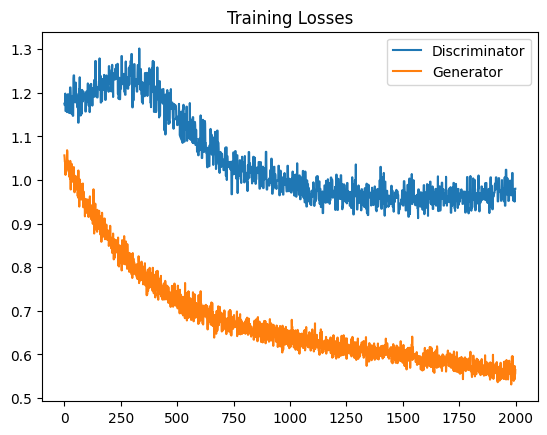

In [26]:
from tensorflow.keras.layers import ReLU, BatchNormalization, Dense, Add, Input, LeakyReLU, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers
import numpy as np
from tqdm import tqdm
import tensorflow as tf

# Define the Generator model
def get_generator(optimizer):
    # Input layer
    input_layer = Input(shape=(64,))

    # First dense layer
    x = Dense(512, kernel_initializer=initializers.glorot_normal(seed=42))(input_layer)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    # Adding a skip connection (residual connection)
    skip = x  # Skip connection at 512 units

    # Second dense layer (keep the same number of units)
    x = Dense(512)(x)  # Ensure this has the same number of units as the skip connection
    x = ReLU()(x)
    x = BatchNormalization()(x)

    # Add the skip connection to the second layer (both at 512 units)
    x = Add()([x, skip])  # Both tensors have the same shape (512)

    # Third dense layer (reduce the dimensions after the skip connection)
    x = Dense(256)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    # Output layer with tanh activation
    output_layer = Dense(64, activation='tanh')(x)

    # Create the model
    generator = Model(inputs=input_layer, outputs=output_layer)
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return generator

# Define the Discriminator model
def get_discriminator(optimizer):
    discriminator = Sequential()

    # First dense layer
    discriminator.add(Dense(256, input_dim=64, kernel_initializer=initializers.glorot_normal(seed=42),
                            kernel_regularizer=regularizers.l2(1e-3)))  # Increased L2 Regularization
    discriminator.add(LeakyReLU(alpha=0.2))  # Use LeakyReLU instead of ReLU to avoid dead neurons
    discriminator.add(Dropout(0.4))  # Increased dropout for regularization

    # Second dense layer with fewer neurons
    discriminator.add(Dense(128, kernel_regularizer=regularizers.l2(1e-3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))  # Higher dropout for better regularization

    # Third dense layer
    discriminator.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))

    # Output layer for binary classification (real vs fake)
    discriminator.add(Dense(1, activation='sigmoid'))

    # Compile the discriminator with a lower learning rate to prevent overpowering the generator
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

# Define the GAN network
def get_gan_network(discriminator, generator, optimizer, input_dim=64):
    discriminator.trainable = False
    gan_input = Input(shape=(input_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

# Hyperparameters
learning_rate_gen = 0.0001  # Generator learning rate
learning_rate_disc = 0.000001  # Further reduced learning rate for discriminator
batch_size = 256
epochs = 1000
adam_gen = tf.keras.optimizers.Adam(learning_rate=learning_rate_gen, beta_1=0.5)
adam_disc = tf.keras.optimizers.Adam(learning_rate=learning_rate_disc, beta_1=0.5)

# Initialize generator, discriminator, and GAN models
input_dim = 64
generator = get_generator(adam_gen)
discriminator = get_discriminator(adam_disc)
gan = get_gan_network(discriminator, generator, adam_gen, input_dim=input_dim)


# Calculate the number of batches based on the batch size
batch_count = x_normal_r.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

# Training Loop
for epoch in range(epochs):
    for index in range(batch_count):
        pbar.update(1)

        # Create a random set of input noise
        noise = np.random.normal(0, 1, size=[batch_size, 64])

        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)

        # Obtain a batch of real samples
        image_batch = x_normal_r[index * batch_size: (index + 1) * batch_size]

        # Stack real and fake samples together
        X = np.vstack((generated_images, image_batch))

        # Labels for real and fake samples
        y_dis = np.ones(2 * batch_size)
        y_dis[:batch_size] = 0

        # Train the discriminator less frequently to allow the generator to improve
        if epoch % 2 == 0:
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

        # Train the generator (via the GAN model)
        noise = np.random.uniform(0, 1, size=[batch_size, 64])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

        # Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs}, Batch {index+1}/{batch_count}, [D loss: {d_loss}] [G loss: {g_loss}]")

# Plot the losses
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()


In [33]:
import numpy as np

# Extract normal and anomalous test data from the generators
x_test_normal, _ = generator_normal[0]  # Extract normal batch (replace [0] with the index you want)
x_test_anomalous, _ = generator_anomalous[0]  # Extract anomalous batch (replace [0] with the index you want)

# Reshape the data to remove the extra dimension (batch_size, 64, 1) -> (batch_size, 64)
x_test_normal = x_test_normal.reshape(x_test_normal.shape[0], x_test_normal.shape[1])
x_test_anomalous = x_test_anomalous.reshape(x_test_anomalous.shape[0], x_test_anomalous.shape[1])

# Pass through the generator to get reconstructions
reconstructed_normal = generator.predict(x_test_normal)
reconstructed_anomalous = generator.predict(x_test_anomalous)

# Compute reconstruction error (MSE)
mse_normal = np.mean(np.square(x_test_normal - reconstructed_normal), axis=1)
mse_anomalous = np.mean(np.square(x_test_anomalous - reconstructed_anomalous), axis=1)

# Compare the errors
print(f'Normal MSE: {np.mean(mse_normal)}')
print(f'Anomalous MSE: {np.mean(mse_anomalous)}')


Normal MSE: 2.7774812523513974
Anomalous MSE: 7.832557967937893


In [35]:
from sklearn.metrics import mean_absolute_error

# Step 1: Pass normal and anomalous data through the discriminator
# Assuming x_test_normal and x_test_anomalous are already defined and reshaped as in the previous steps
discriminator_normal_pred = discriminator.predict(x_test_normal)
discriminator_anomalous_pred = discriminator.predict(x_test_anomalous)

# Step 2: Define the true labels
# For normal data, the true label is 1 (real)
y_true_normal = np.ones(len(discriminator_normal_pred))

# For anomalous data, the true label is 0 (fake/anomalous)
y_true_anomalous = np.zeros(len(discriminator_anomalous_pred))

# Step 3: Calculate MAE for normal data
mae_normal = mean_absolute_error(y_true_normal, discriminator_normal_pred)

# Step 4: Calculate MAE for anomalous data
mae_anomalous = mean_absolute_error(y_true_anomalous, discriminator_anomalous_pred)

# Step 5: Print the MAE values
print(f'MAE for normal data (should be close to 1): {mae_normal}')
print(f'MAE for anomalous data (should be close to 0): {mae_anomalous}')


MAE for normal data (should be close to 1): 0.2336850015562959
MAE for anomalous data (should be close to 0): 0.8162023395125289


In [36]:
# Calculate the 95th percentile of the normal MSE as the threshold
threshold_mse = np.percentile(mse_normal, 95)
print(f"Threshold for MSE: {threshold_mse}")

# Similarly, you can calculate the threshold for MAE if you're using the discriminator's MAE
threshold_mae = np.percentile(mae_normal, 95)
print(f"Threshold for MAE: {threshold_mae}")


Threshold for MSE: 2.81172099312407
Threshold for MAE: 0.2336850015562959


In [49]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

# Generate a range of possible thresholds
thresholds = np.linspace(0, max(np.max(mse_normal), np.max(mse_anomalous)), 100)

# Initialize lists to store the evaluation metrics for each threshold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Sweep through thresholds and compute metrics
for threshold in thresholds:
    # Classify based on the current threshold
    y_pred_mse_normal = (mse_normal > threshold).astype(int)
    y_pred_mse_anomalous = (mse_anomalous > threshold).astype(int)

    # Concatenate the predictions
    y_pred_mse = np.concatenate([y_pred_mse_normal, y_pred_mse_anomalous])

    # True labels
    y_true_normal = np.zeros(len(mse_normal))
    y_true_anomalous = np.ones(len(mse_anomalous))
    y_true = np.concatenate([y_true_normal, y_true_anomalous])

    # Calculate evaluation metrics for the current threshold
    accuracy = accuracy_score(y_true, y_pred_mse)
    precision = precision_score(y_true, y_pred_mse, zero_division=0)  # Prevent precision from being undefined
    recall = recall_score(y_true, y_pred_mse)
    f1 = f1_score(y_true, y_pred_mse)

    # Store the metrics
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Find the index of the best F1-score
best_f1_idx = np.argmax(f1_list)
best_threshold_f1 = thresholds[best_f1_idx]

# Generate classification report using the best threshold based on F1-score
y_pred_mse_best = np.concatenate([
    (mse_normal > best_threshold_f1).astype(int),
    (mse_anomalous > best_threshold_f1).astype(int)
])

# True labels
y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomalous))])

# Generate the classification report
report = classification_report(y_true, y_pred_mse_best, target_names=['Normal', 'Anomalous'])

# Print the best threshold and the classification report
print(f"Best threshold based on F1-score: {best_threshold_f1}")
print(f"Classification Report (Using Best Threshold):\n{report}")


Best threshold based on F1-score: 2.843879619469066
Classification Report (Using Best Threshold):
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94      1024
   Anomalous       1.00      0.87      0.93      1024

    accuracy                           0.94      2048
   macro avg       0.94      0.94      0.94      2048
weighted avg       0.94      0.94      0.94      2048



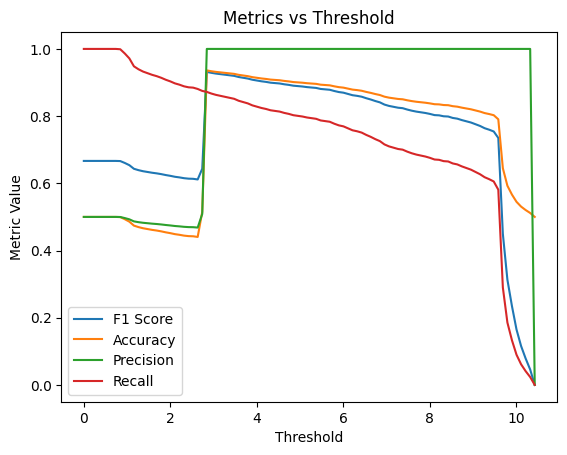

In [42]:
import matplotlib.pyplot as plt

# Plot F1-score vs Threshold
plt.plot(thresholds, f1_list, label='F1 Score')
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs Threshold')
plt.legend()
plt.show()
